# Sepsis Data - Cleaning and EDA


In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 6]

In [7]:
# load the data 
train = pd.read_csv("sepsis_train.csv")

In [8]:
# downsample to 1000 paients, remove random column and set filename as index
#train = train[train.filename.isin(train.filename.unique()[1:1001])].drop('Unnamed: 0', axis=1).set_index('filename')
train = train.drop('Unnamed: 0', axis=1).set_index('filename')
train.shape

(931890, 42)

In [9]:
train['GotSepsis'] = train.groupby('filename').apply(func = lambda x: np.sum(x.SepsisLabel) > 0)
train.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Hospital,GotSepsis
filename,,,,,,,,,,,,,,,,,,,,,
p000005.psv,84.0,97.5,37.28,140.5,94.5,NaN,17.5,NaN,NaN,NaN,...,NaN,28.09,1,1.0,0.0,-0.05,2,0,A,False
p000005.psv,80.0,99.0,NaN,150.0,99.0,NaN,18.0,NaN,NaN,NaN,...,NaN,28.09,1,1.0,0.0,-0.05,3,0,A,False
p000005.psv,74.0,97.0,37.22,142.0,103.0,NaN,19.0,NaN,NaN,NaN,...,NaN,28.09,1,1.0,0.0,-0.05,4,0,A,False
p000005.psv,73.0,98.0,NaN,144.0,99.0,NaN,17.0,NaN,NaN,NaN,...,NaN,28.09,1,1.0,0.0,-0.05,5,0,A,False
p000005.psv,71.0,97.0,NaN,144.0,NaN,NaN,17.0,NaN,NaN,24.0,...,273.0,28.09,1,1.0,0.0,-0.05,6,0,A,False


### Assessing Feature Missingness (across all rows)

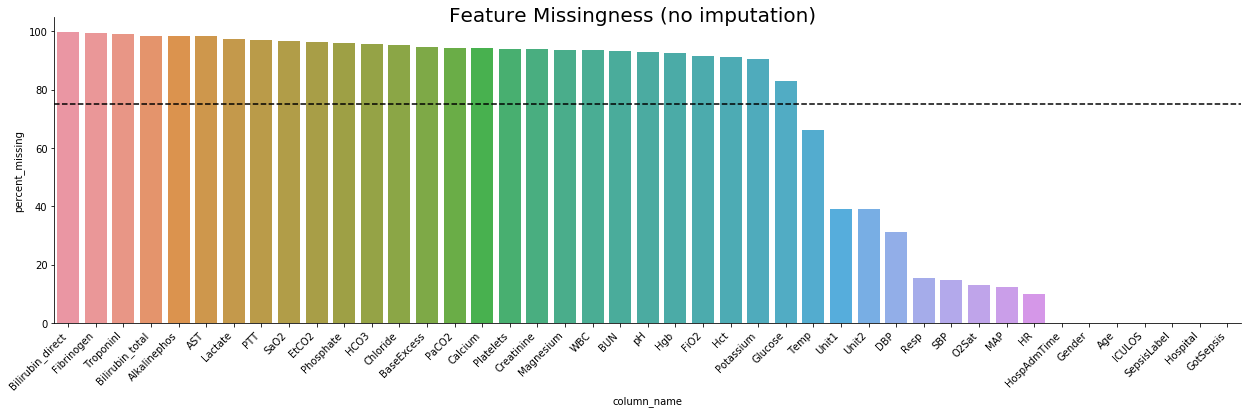

,column_name,percent_missing
Bilirubin_direct,Bilirubin_direct,99.803947
Fibrinogen,Fibrinogen,99.323096
TroponinI,TroponinI,99.056219
Bilirubin_total,Bilirubin_total,98.506154
Alkalinephos,Alkalinephos,98.381676
AST,AST,98.365365
Lactate,Lactate,97.289702
PTT,PTT,97.024649
SaO2,SaO2,96.523302
EtCO2,EtCO2,96.410091


In [10]:
def percent_missing(data, title, line=75):
    percent_missing = data.isnull().sum() * 100 / len(data)
    missing_value_df = pd.DataFrame({'column_name': data.columns,
                                     'percent_missing': percent_missing})
    missing_value_sorted = missing_value_df.sort_values('percent_missing', ascending=False, inplace=False)

    g = sns.catplot(x='column_name', y='percent_missing', kind='bar', data=missing_value_sorted, height = 5, aspect=3.5)
    g.set_xticklabels(rotation=45, horizontalalignment='right')
    g.fig.suptitle(title, size=20, y=1)
    g.axes[0][0].axhline(line, ls='--', color='black')
    plt.show()
    
    return(missing_value_df)
    
percent_missing_noimpute = percent_missing(train, 'Feature Missingness (no imputation)', line = 75)
percent_missing_noimpute.sort_values('percent_missing', ascending=False).head(10)

### Imputing with ffill and Assigning Missing Values as -1

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

def clean_and_impute(data, catvars, line = 75):
    # ffill imputation
    data = data.groupby('filename').fillna(method = 'ffill')
    
    # percent missing
    missing_df = percent_missing(data, "Feature Missingness (after forward fill)", line)
    
    # remove missing above 75% after ffill
    data = data[missing_df[missing_df.percent_missing < 75].index]
    
    # MinMaxScale numeric variables to [0,1]
    scaler = MinMaxScaler()
    data[data.columns[~data.columns.isin(catvars)]] = scaler.fit_transform(data[data.columns[~data.columns.isin(catvars)]])
    
    # Fill in remaining missing values as -1
    imp = SimpleImputer(strategy = 'constant', fill_value = -1)
    data[data.columns[~data.columns.isin(catvars)]] = imp.fit_transform(data[data.columns[~data.columns.isin(catvars)]])

    return(data)

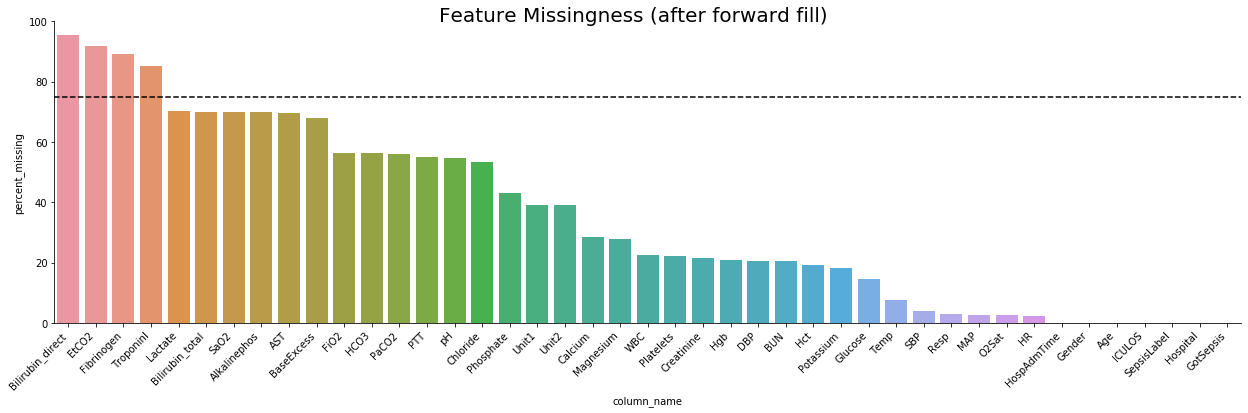

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Hospital,GotSepsis
filename,,,,,,,,,,,,,,,,,,,,,
p000005.psv,0.315271,0.96875,0.562887,0.430357,0.266071,-1.0,0.166667,-1.0,-1.000000,-1.0,...,-1.000000,0.163837,1,1.0,0.0,0.993563,2,0,A,False
p000005.psv,0.295567,0.98750,0.562887,0.464286,0.282143,-1.0,0.171717,-1.0,-1.000000,-1.0,...,-1.000000,0.163837,1,1.0,0.0,0.993563,3,0,A,False
p000005.psv,0.266010,0.96250,0.560825,0.435714,0.296429,-1.0,0.181818,-1.0,-1.000000,-1.0,...,-1.000000,0.163837,1,1.0,0.0,0.993563,4,0,A,False
p000005.psv,0.261084,0.97500,0.560825,0.442857,0.282143,-1.0,0.161616,-1.0,-1.000000,-1.0,...,-1.000000,0.163837,1,1.0,0.0,0.993563,5,0,A,False
p000005.psv,0.251232,0.96250,0.560825,0.442857,0.282143,-1.0,0.161616,-1.0,0.436364,-1.0,...,0.117191,0.163837,1,1.0,0.0,0.993563,6,0,A,False
p000005.psv,0.251232,0.96250,0.560825,0.442857,0.282143,-1.0,0.161616,-1.0,0.436364,-1.0,...,0.117191,0.163837,1,1.0,0.0,0.993563,7,0,A,False
p000005.psv,0.231527,0.96250,0.564605,0.414286,0.235714,-1.0,0.181818,-1.0,0.436364,-1.0,...,0.117191,0.163837,1,1.0,0.0,0.993563,8,0,A,False
p000005.psv,0.270936,0.96250,0.564605,0.403571,0.239286,-1.0,0.151515,-1.0,0.436364,-1.0,...,0.117191,0.163837,1,1.0,0.0,0.993563,9,0,A,False
p000005.psv,0.231527,0.96250,0.564605,0.392857,0.242857,-1.0,0.151515,-1.0,0.436364,-1.0,...,0.117191,0.163837,1,1.0,0.0,0.993563,10,0,A,False


In [12]:
catvars = ['Gender', 'Unit1', 'Unit2', 'Hospital', 'SepsisLabel', 'ICULOS', 'GotSepsis']

cleaned = clean_and_impute(train, catvars, line = 75)
cleaned.head(10)

In [13]:
# Save Training 
cleaned.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Hospital,GotSepsis
filename,,,,,,,,,,,,,,,,,,,,,
p000005.psv,0.315271,0.96875,0.562887,0.430357,0.266071,-1.0,0.166667,-1.0,-1.000000,-1.0,...,-1.000000,0.163837,1,1.0,0.0,0.993563,2,0,A,False
p000005.psv,0.295567,0.98750,0.562887,0.464286,0.282143,-1.0,0.171717,-1.0,-1.000000,-1.0,...,-1.000000,0.163837,1,1.0,0.0,0.993563,3,0,A,False
p000005.psv,0.266010,0.96250,0.560825,0.435714,0.296429,-1.0,0.181818,-1.0,-1.000000,-1.0,...,-1.000000,0.163837,1,1.0,0.0,0.993563,4,0,A,False
p000005.psv,0.261084,0.97500,0.560825,0.442857,0.282143,-1.0,0.161616,-1.0,-1.000000,-1.0,...,-1.000000,0.163837,1,1.0,0.0,0.993563,5,0,A,False
p000005.psv,0.251232,0.96250,0.560825,0.442857,0.282143,-1.0,0.161616,-1.0,0.436364,-1.0,...,0.117191,0.163837,1,1.0,0.0,0.993563,6,0,A,False


In [1069]:
# Save Training 
#cleaned.to_csv("train_cleaned_ffill_NA_constant.csv")

### Validation Set

In [16]:
# load the data 
val = pd.read_csv("sepsis_val.csv")
val = val.drop('Unnamed: 0', axis=1).set_index('filename')
val['GotSepsis'] = val.groupby('filename').apply(func = lambda x: np.sum(x.SepsisLabel) > 0)

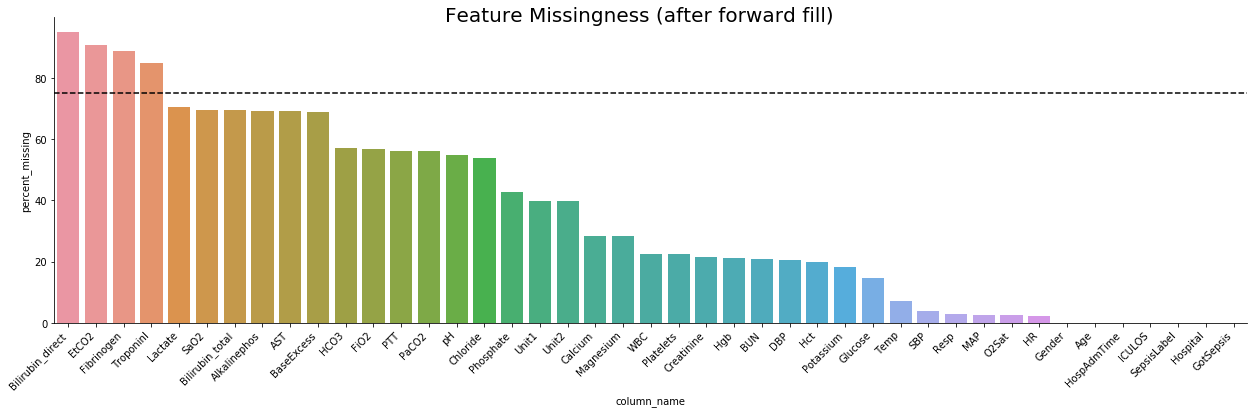

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Hospital,GotSepsis
filename,,,,,,,,,,,,,,,,,,,,,
p000002.psv,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,...,-1.000000,0.719884,0,0.0,1.0,0.979036,1,0,A,False
p000002.psv,0.157692,0.9875,0.532414,0.376812,0.162455,0.083333,0.168367,-1.0,-1.000000,-1.0,...,-1.000000,0.719884,0,0.0,1.0,0.979036,2,0,A,False
p000002.psv,0.169231,0.9750,0.532414,0.380435,0.158845,0.076087,0.265306,-1.0,-1.000000,-1.0,...,-1.000000,0.719884,0,0.0,1.0,0.979036,3,0,A,False
p000002.psv,0.138462,1.0000,0.532414,0.373188,0.162455,0.076087,0.081633,-1.0,-1.000000,-1.0,...,-1.000000,0.719884,0,0.0,1.0,0.979036,4,0,A,False
p000002.psv,0.176923,0.9875,0.532414,0.362319,0.169675,0.083333,0.224490,-1.0,-1.000000,-1.0,...,-1.000000,0.719884,0,0.0,1.0,0.979036,5,0,A,False
p000002.psv,0.284615,1.0000,0.524828,0.630435,0.346570,0.166667,0.132653,-1.0,-1.000000,-1.0,...,-1.000000,0.719884,0,0.0,1.0,0.979036,6,0,A,False
p000002.psv,0.146154,0.9875,0.524828,0.409420,0.173285,0.083333,0.122449,-1.0,-1.000000,-1.0,...,-1.000000,0.719884,0,0.0,1.0,0.979036,7,0,A,False
p000002.psv,0.142308,1.0000,0.524828,0.355072,0.151625,0.061594,0.173469,-1.0,-1.000000,-1.0,...,-1.000000,0.719884,0,0.0,1.0,0.979036,8,0,A,False
p000002.psv,0.161538,1.0000,0.524828,0.384058,0.166065,0.061594,0.112245,-1.0,-1.000000,-1.0,...,-1.000000,0.719884,0,0.0,1.0,0.979036,9,0,A,False


In [17]:
catvars = ['Gender', 'Unit1', 'Unit2', 'Hospital', 'SepsisLabel', 'ICULOS', 'GotSepsis']

cleaned_val = clean_and_impute(val, catvars, line = 75)
cleaned_val.head(10)

In [1074]:
# Save validation 
#cleaned_val.to_csv("val_cleaned_ffill_NA_constant.csv")

## Sample and Hold

In [6]:
def collection_times(data):
    
    # get first and last non-missing value 
    first_and_last = np.where(~pd.isna(data))
    first = first_and_last[0][0]
    last = first_and_last[0][len(first_and_last[0])-1]
    data = data.iloc[first:last]
    
    # find total collections per person and averaage time between connections
    collections_per_person = len(data) - data.isnull().sum()
    time_between_collections = len(data) / (len(data) - data.isnull().sum())
    
    df = pd.DataFrame({"count": collections_per_person, "time":time_between_collections})

    return(df)

In [18]:
collect = train[train.columns[~train.columns.isin(catvars)]].groupby('filename').apply(func = collection_times)

# sepsis labels
train_sepsis = train[['GotSepsis']].reset_index().drop_duplicates().set_index('filename')

# total collections per patient
collections_per_person = collect[['count']].unstack()
collections_per_person.columns = collections_per_person.columns.droplevel() # drop top level
collections_per_person['GotSepsis'] = train_sepsis['GotSepsis']

# avg hours between collections, replace inf with NaN (no observations)
time_between_collections = collect[['time']].unstack().replace([np.inf,-np.inf], np.nan)
time_between_collections.columns = time_between_collections.columns.droplevel() # drop top level
time_between_collections['GotSepsis'] = train_sepsis['GotSepsis']

In [19]:
def plot_histograms(data, ascend, count_interval):
    data_mean = data.mean()
    data_nosepsis = data[data.GotSepsis == False]
    data_sepsis = data[data.GotSepsis == True]
    
    for column in data_mean.sort_values(ascending = ascend).index.values:    
        
        column_mean = np.round(data_mean[column],2).astype("str")
        sns.distplot(data_nosepsis[column], color = 'royalblue', bins=75)
        sns.distplot(data_sepsis[column], color = 'red', bins=75)
        plt.title(column+"  (mean "+count_interval+"= "+column_mean+")", fontsize=18)
        plt.savefig("figures/data_cleaning/"+count_interval+"/"+column+"_"+count_interval+".png")
        plt.show()

In [20]:
pd.DataFrame({"mean": time_between_collections.mean(),
              "median": time_between_collections.median()})

,mean,median
HR,1.206709,1.062500
O2Sat,1.300892,1.083333
Temp,4.014613,4.000000
SBP,1.375289,1.090909
MAP,1.332426,1.083333
DBP,1.664150,1.100000
Resp,1.372676,1.105263
EtCO2,8.510084,3.500000
BaseExcess,12.610490,7.333333
HCO3,15.659230,14.000000


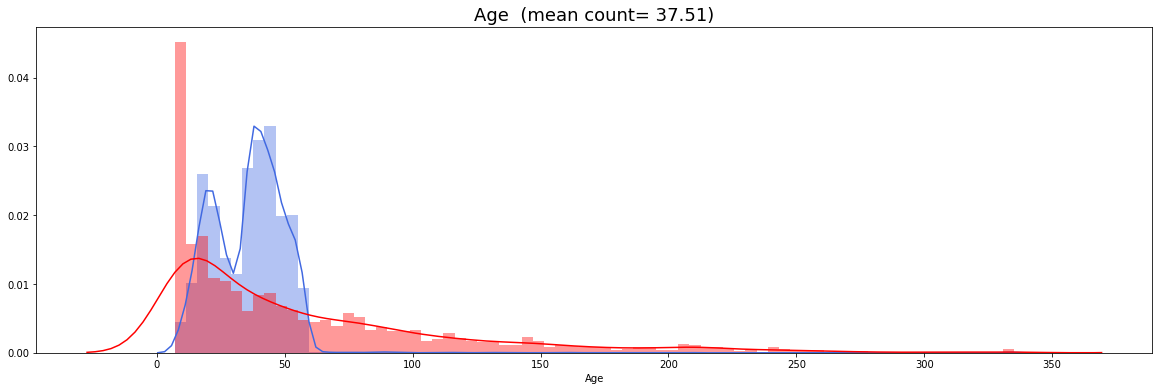

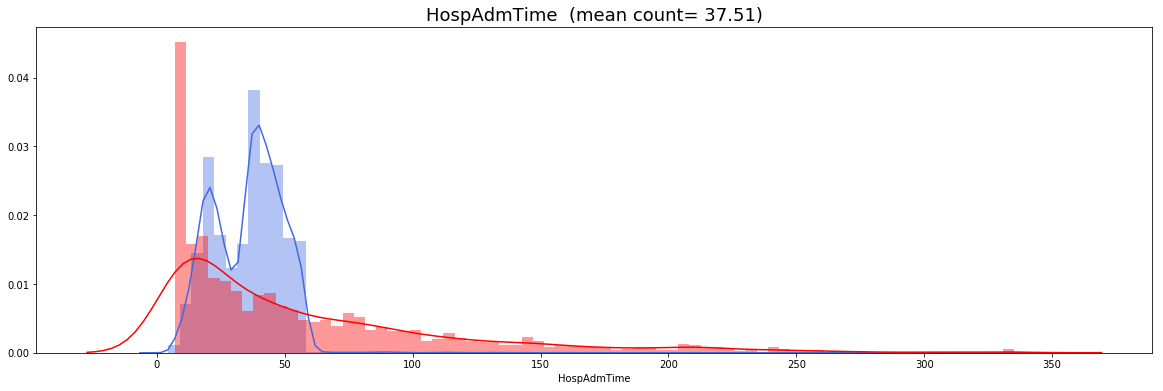

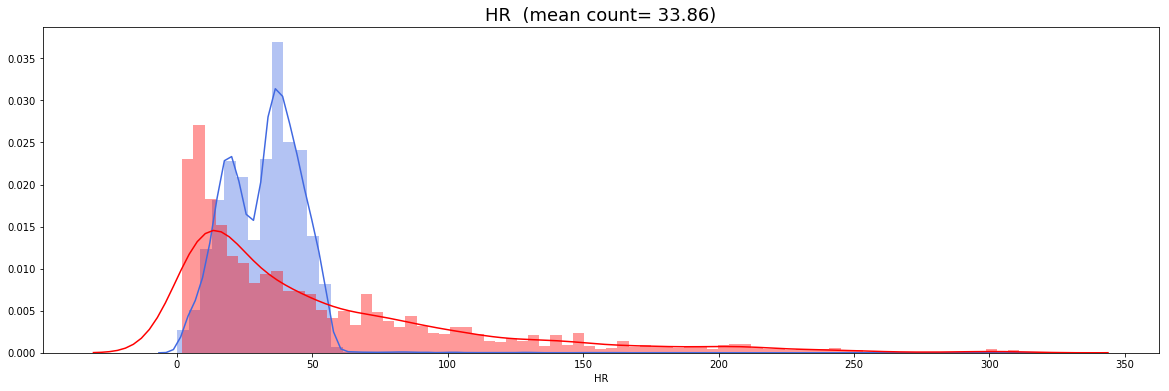

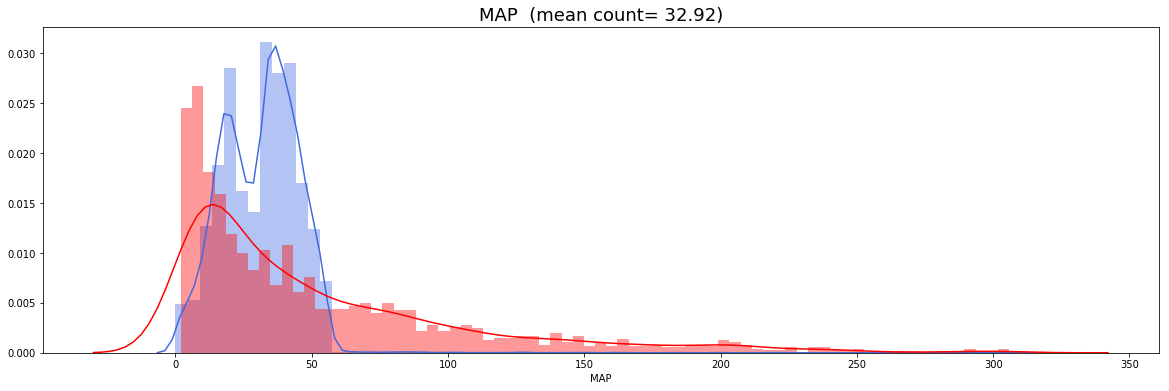

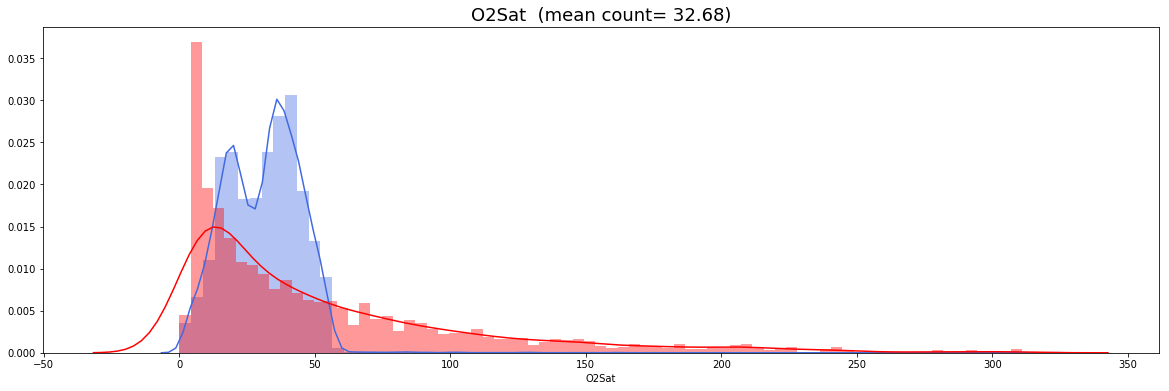

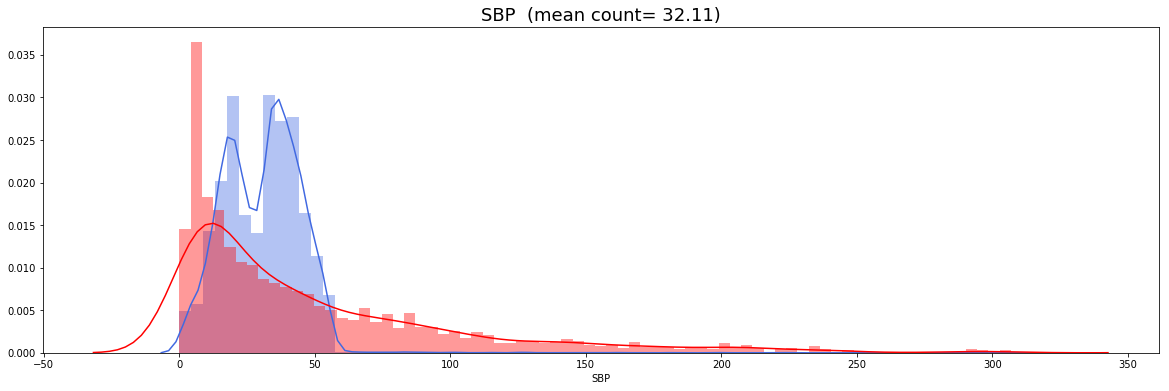

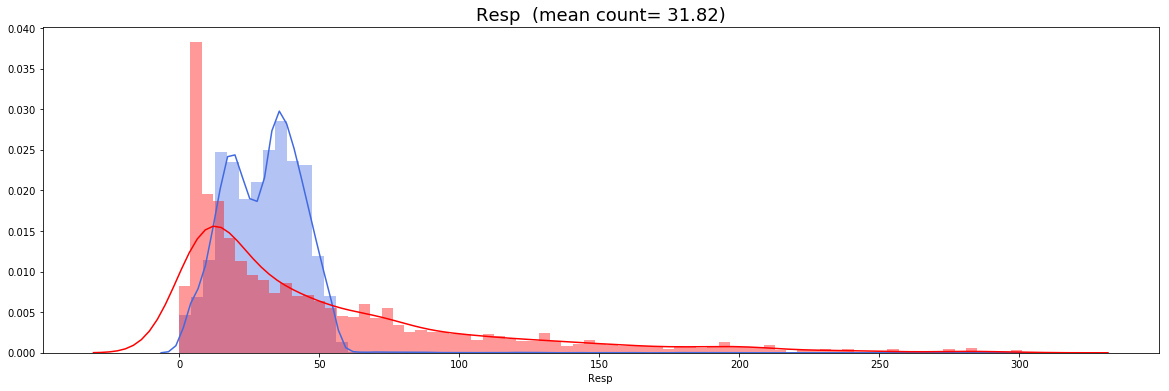

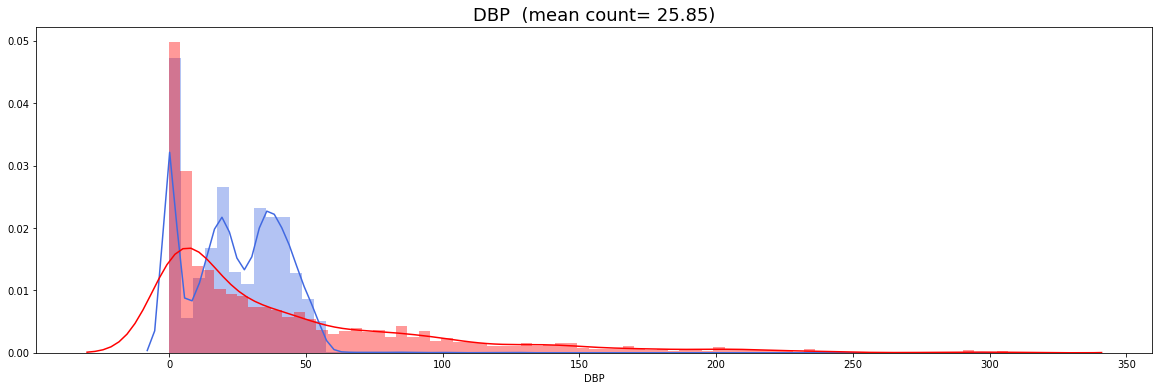

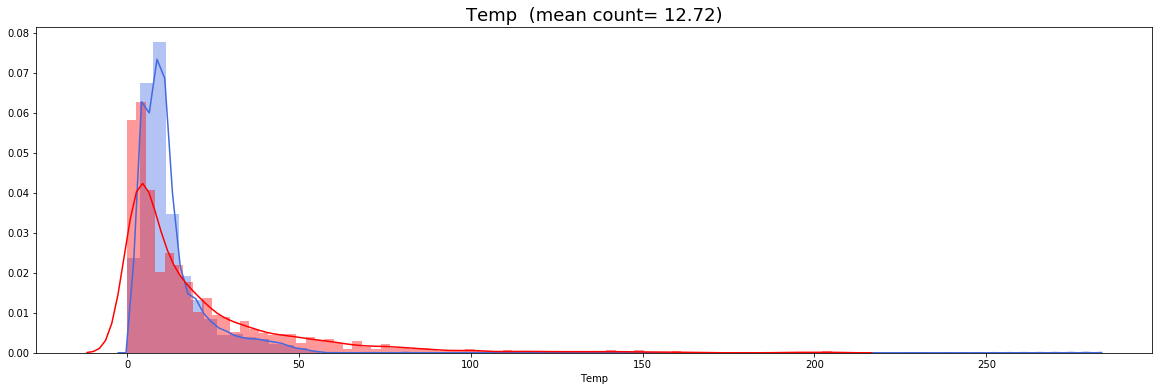

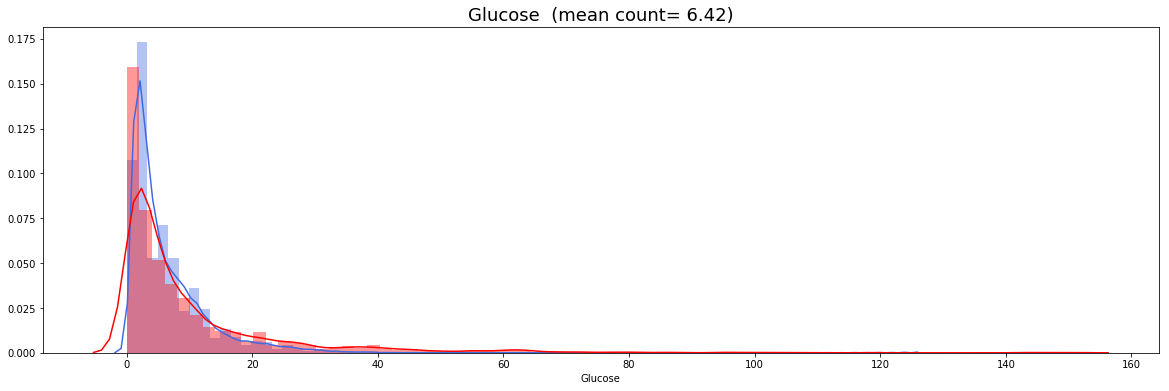

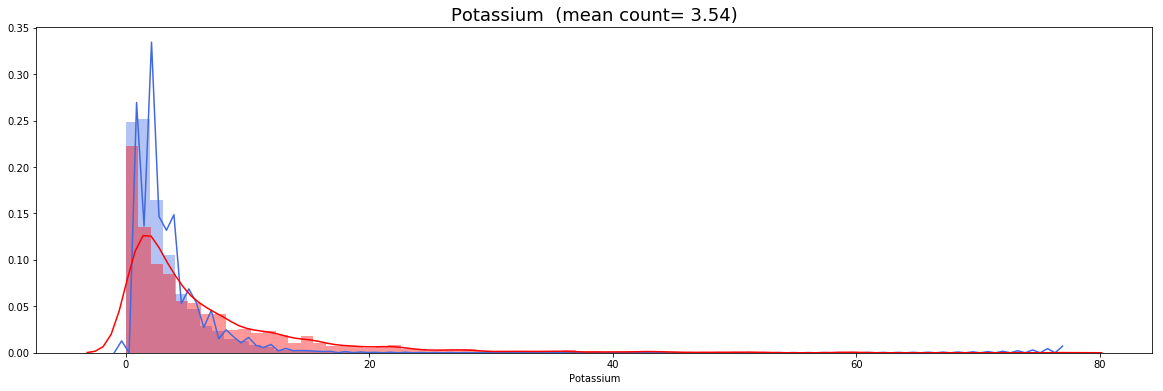

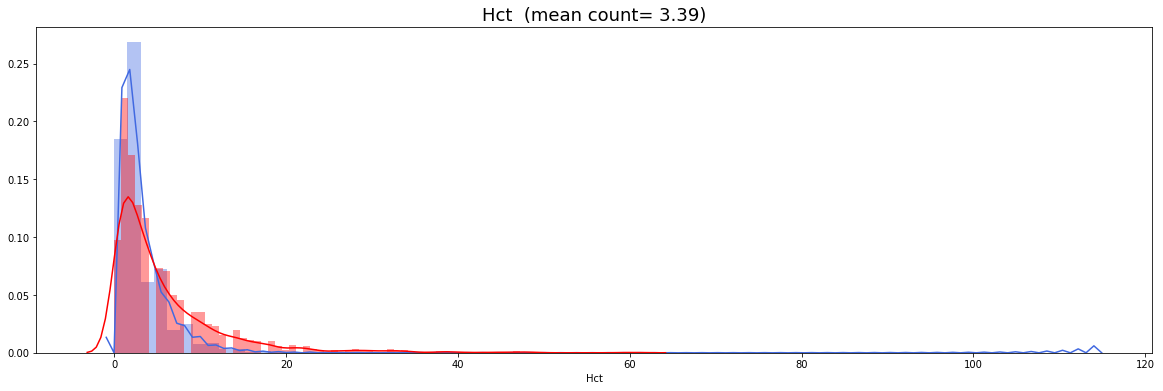

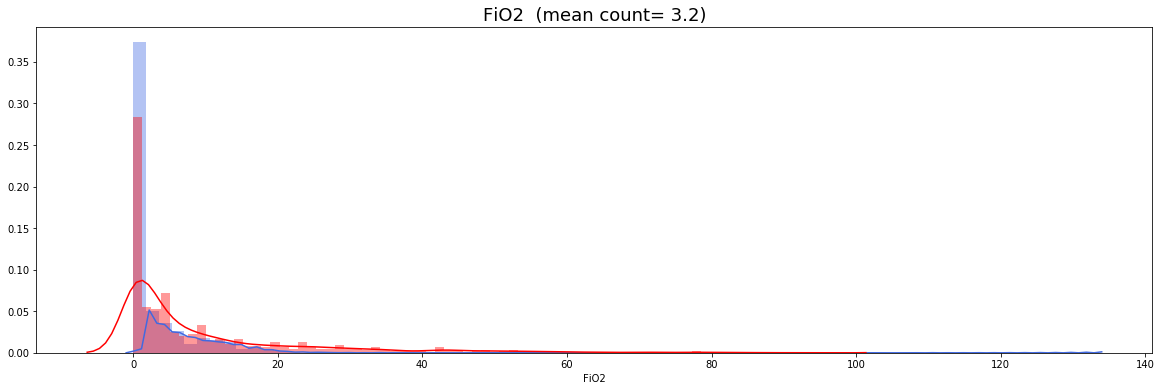

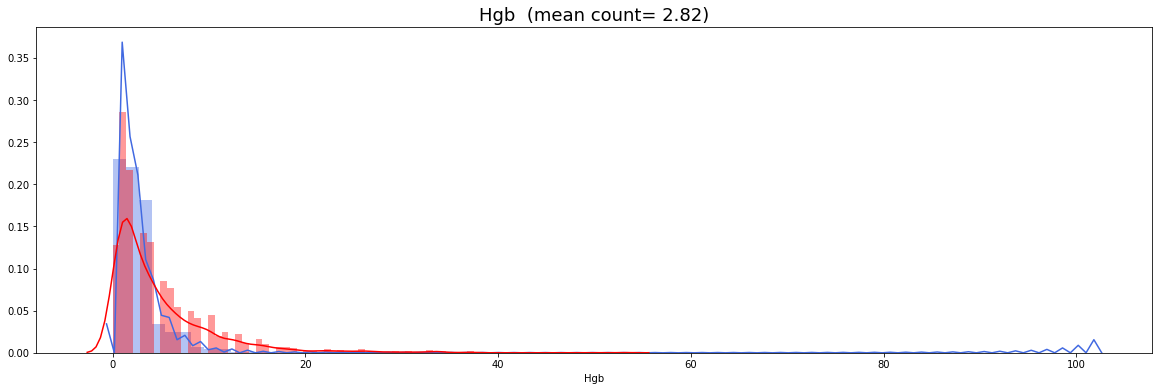

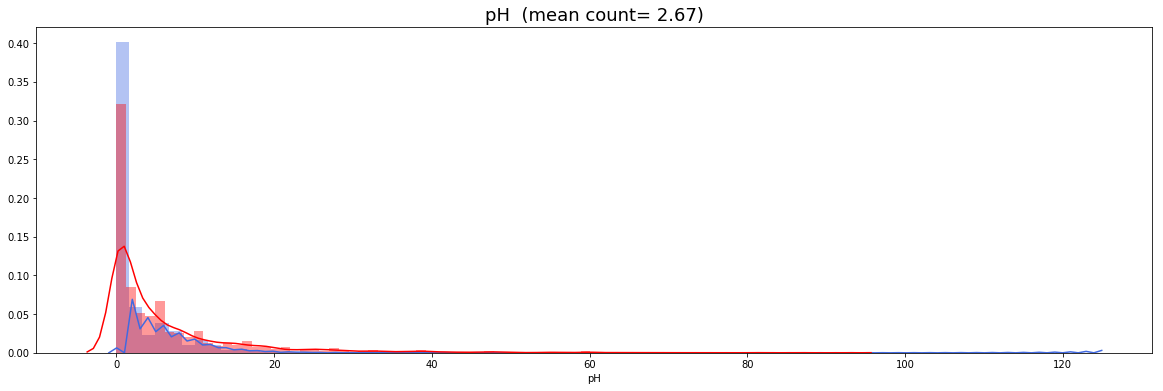

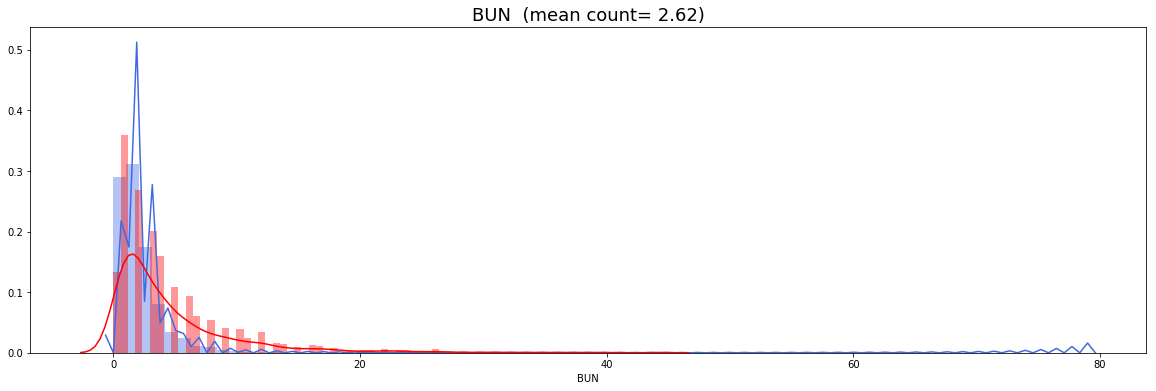

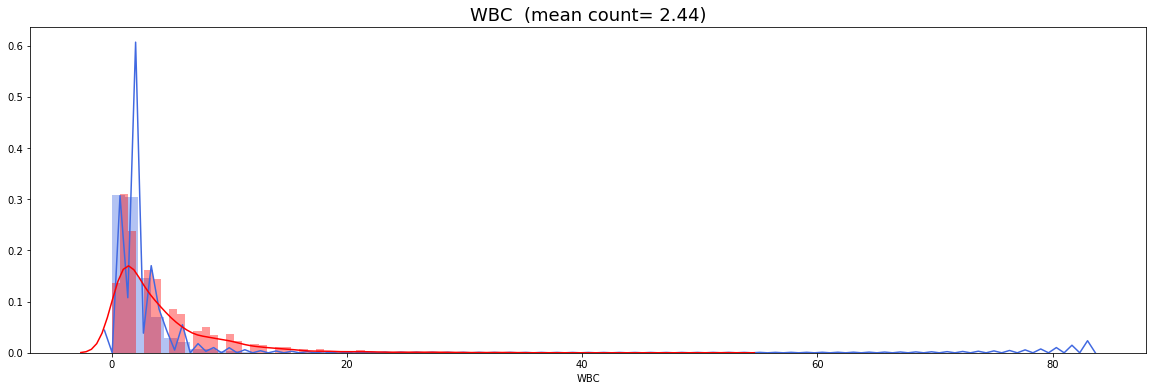

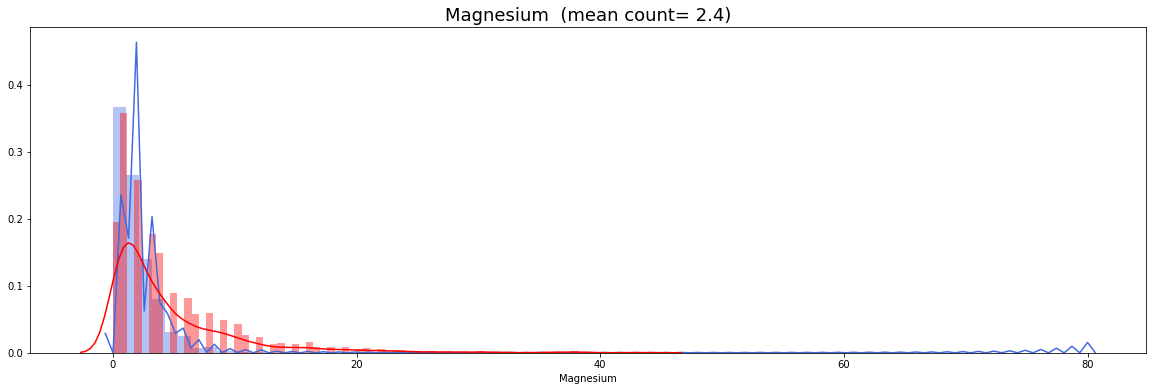

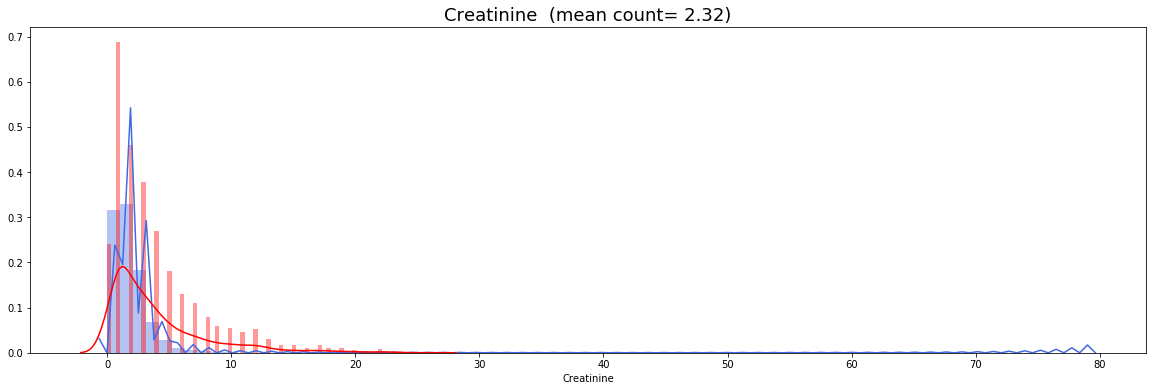

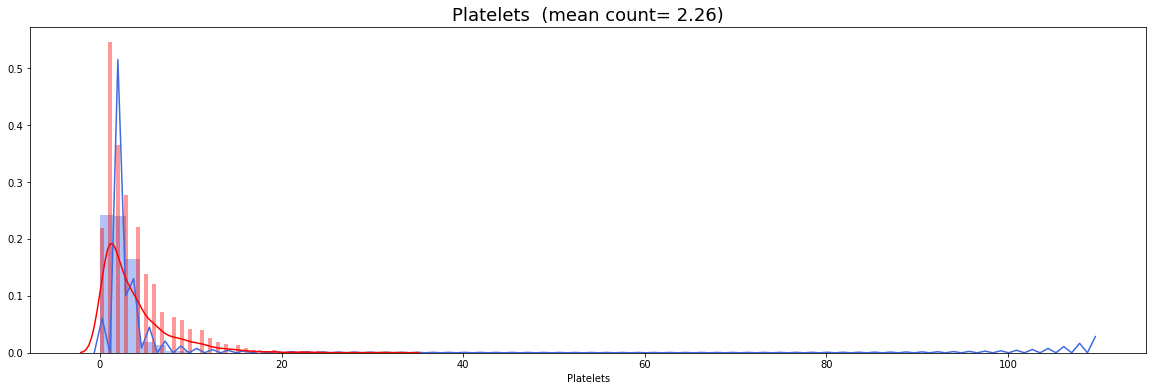

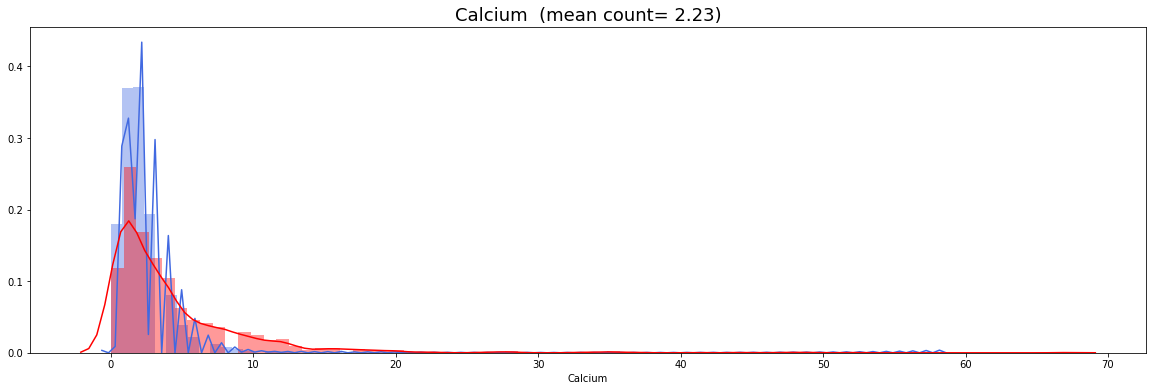

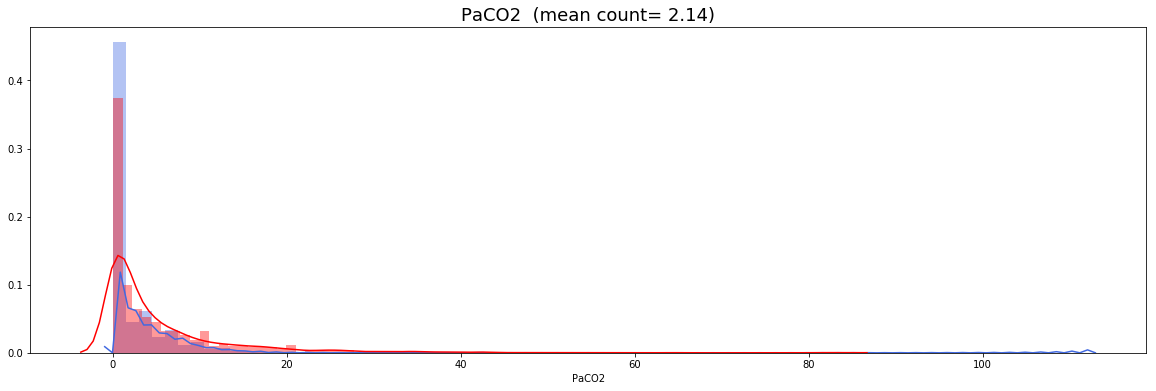

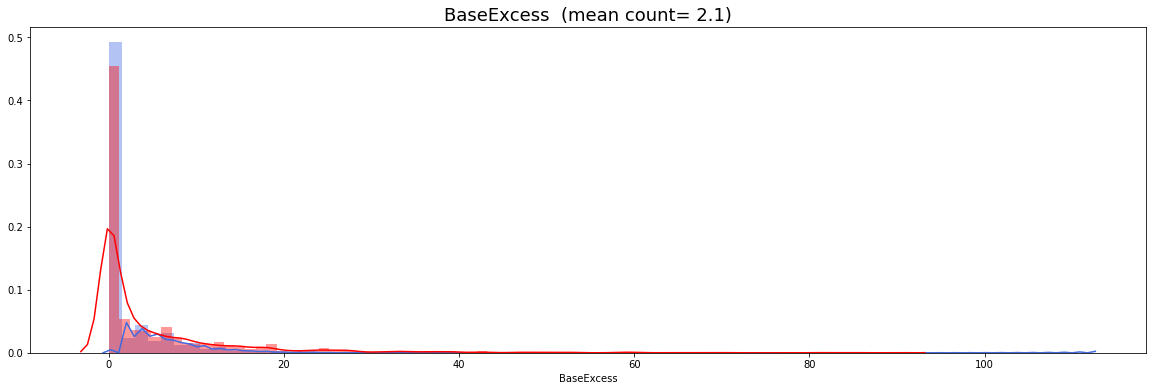

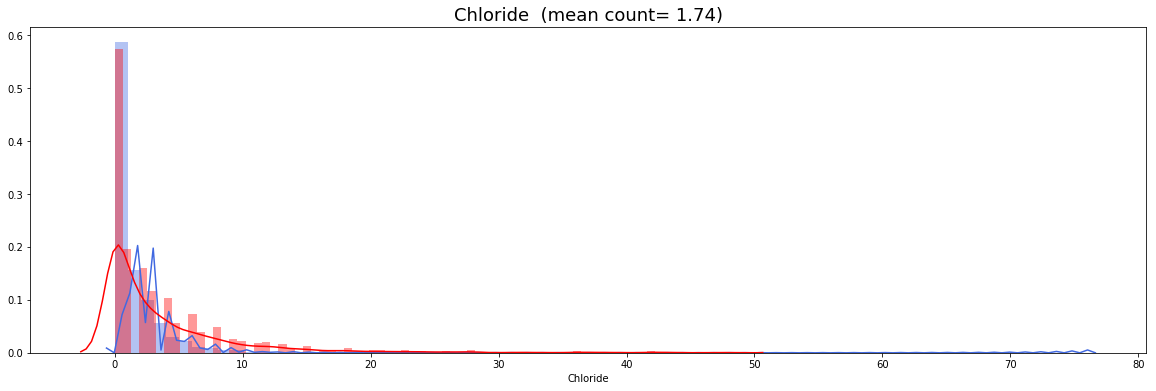

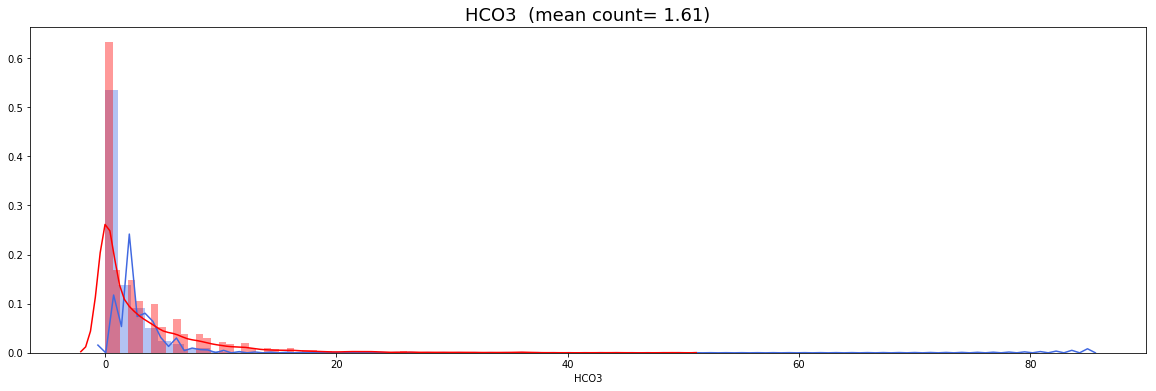

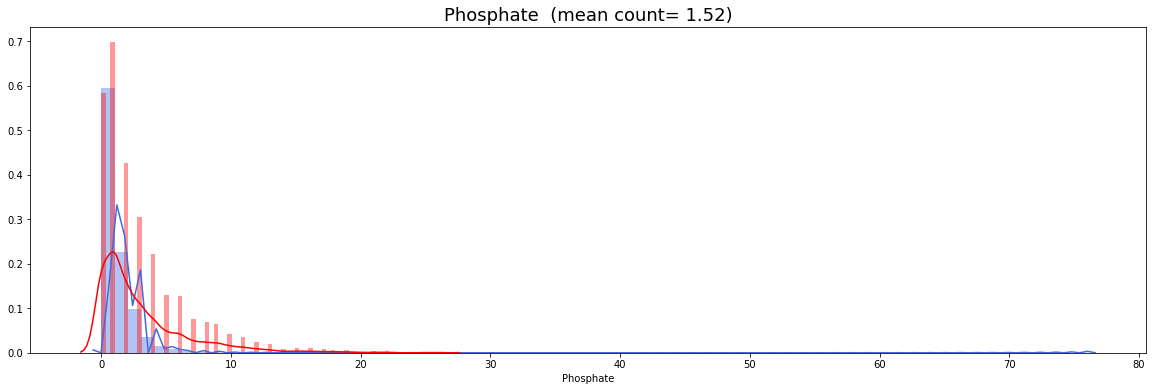

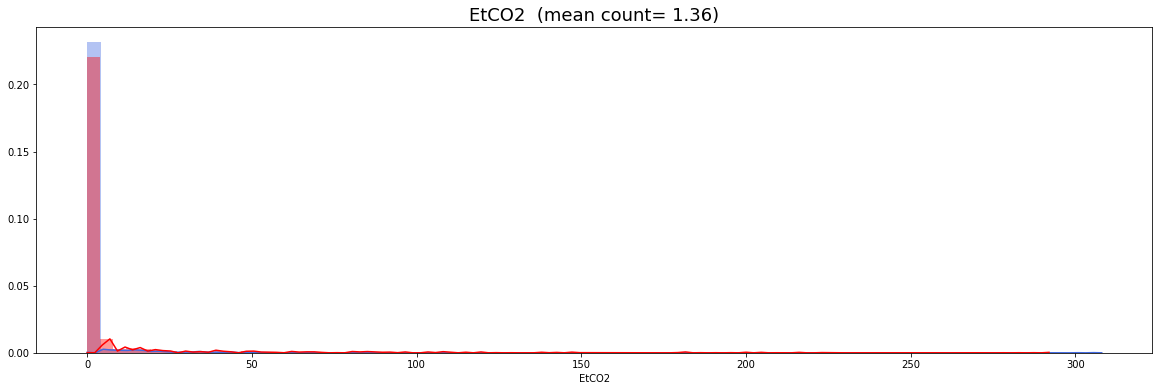

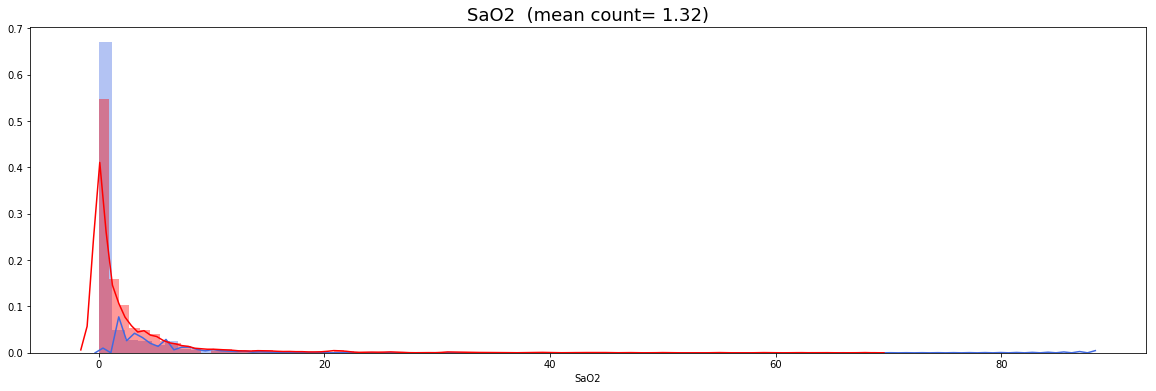

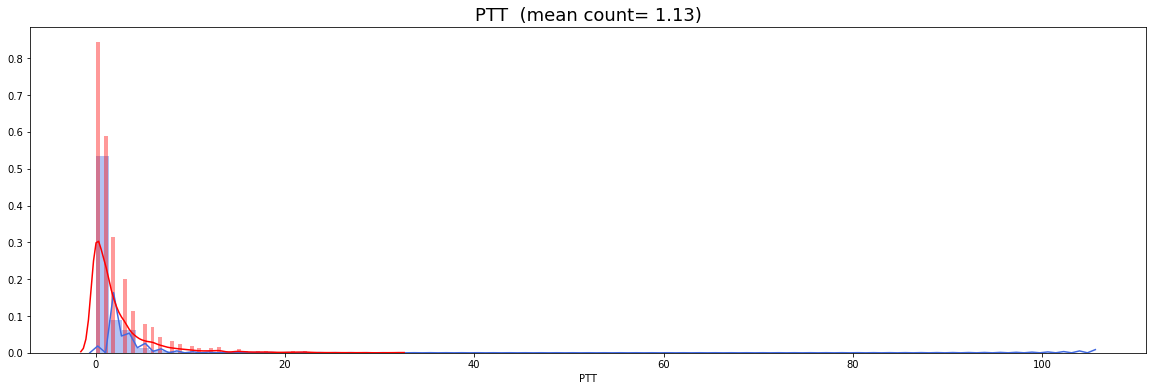

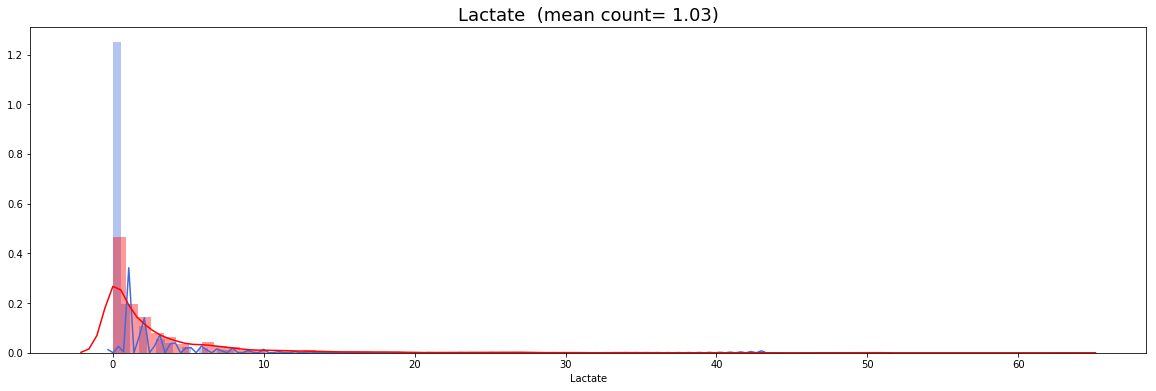

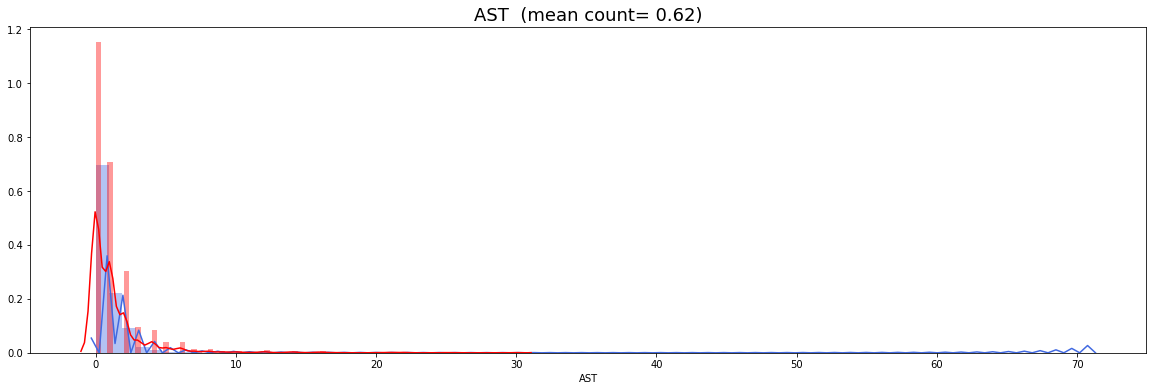

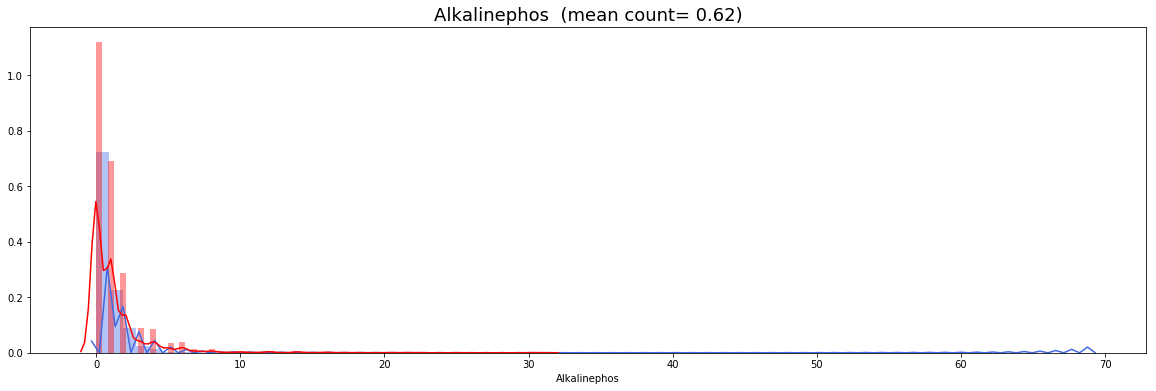

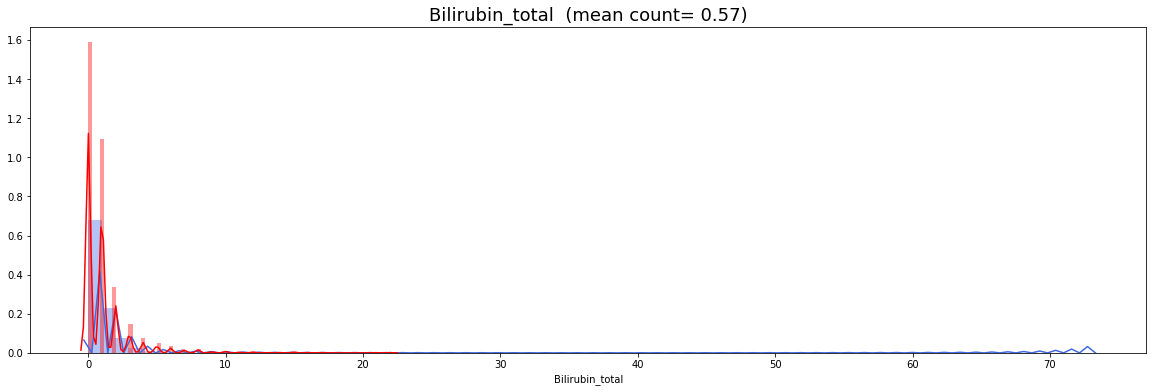

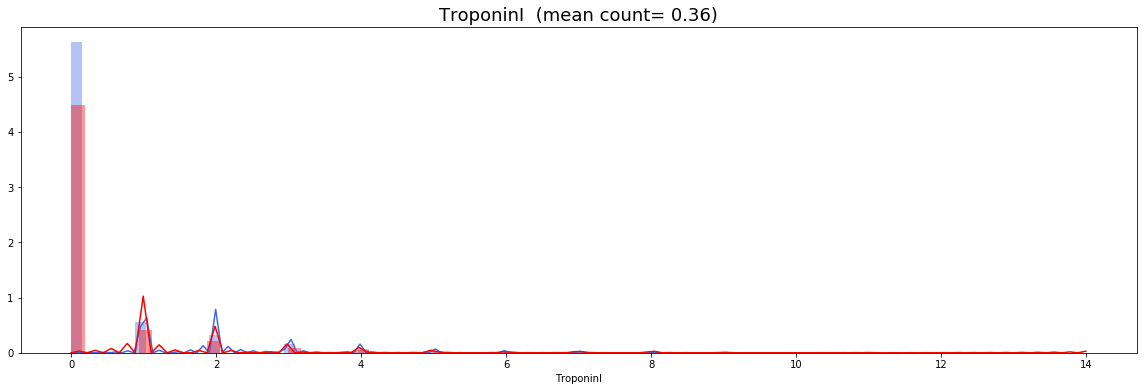

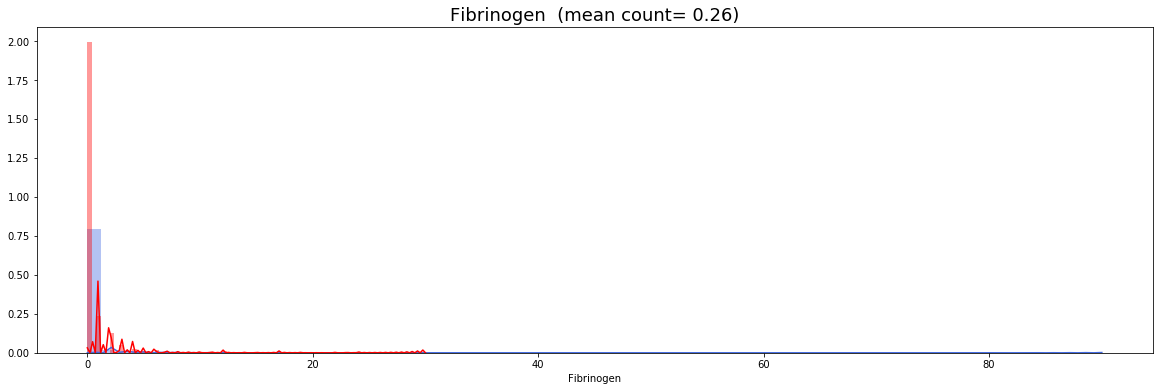

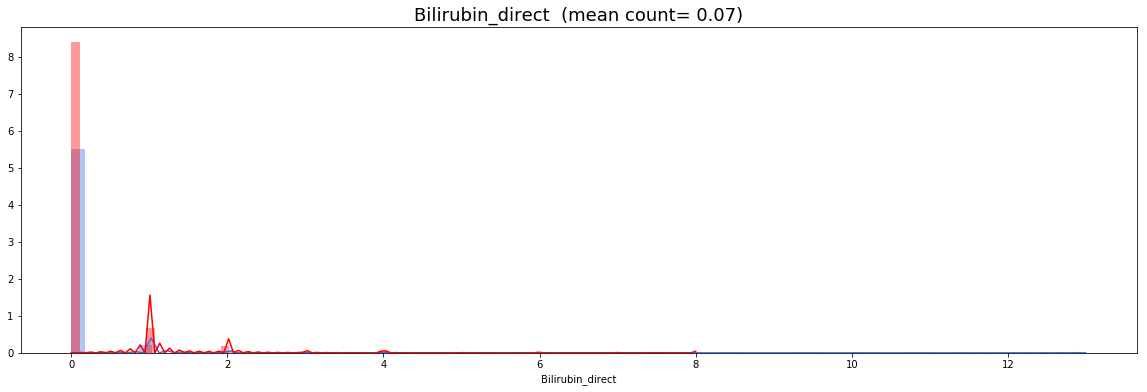

/home/azeng/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)
/home/azeng/miniconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/azeng/miniconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


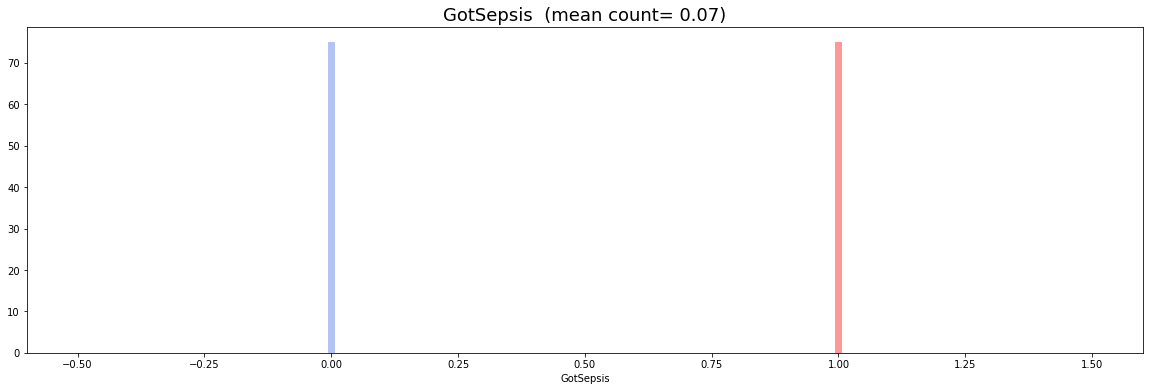

In [828]:
plot_histograms(collections_per_person, ascend = False, count_interval = "count")

/home/azeng/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/azeng/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/azeng/miniconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/azeng/miniconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


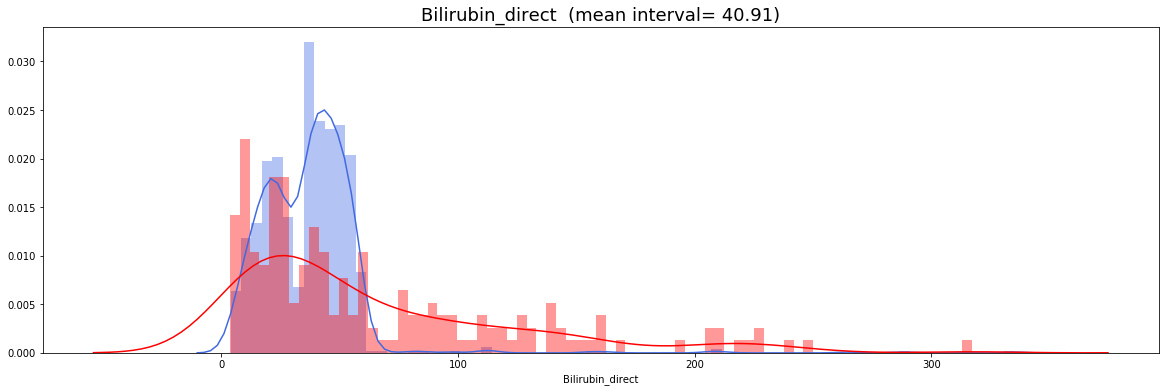

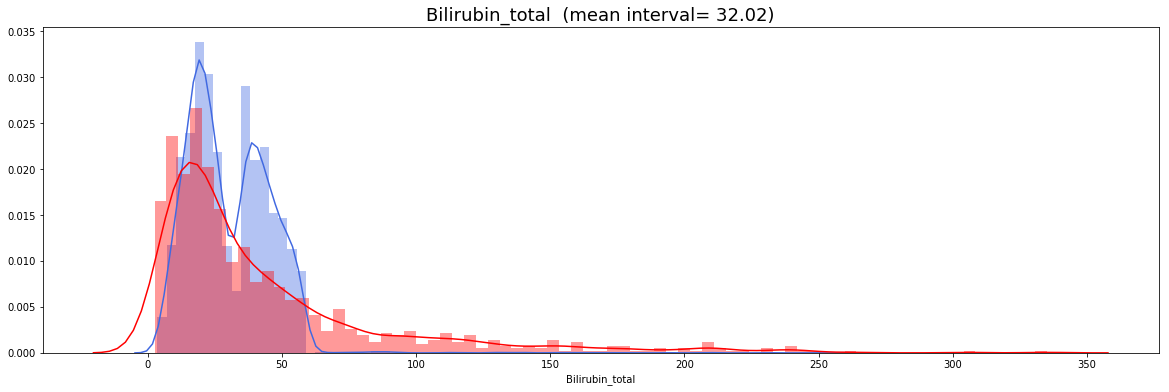

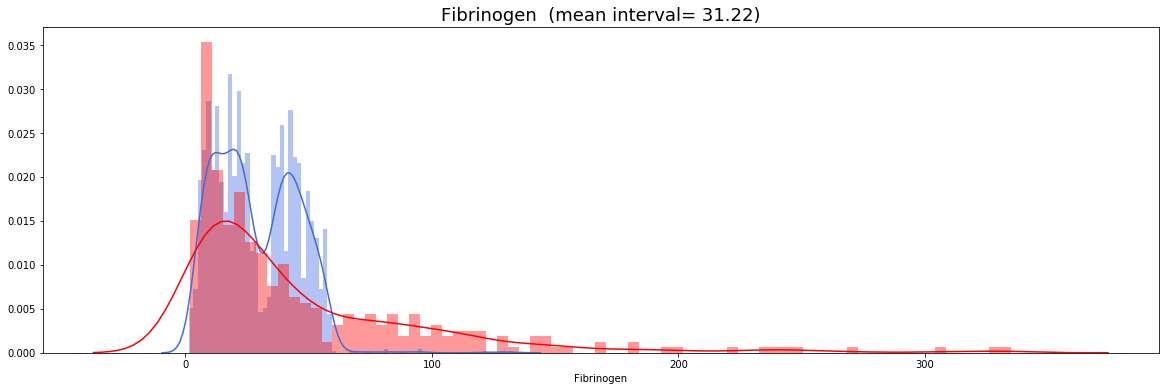

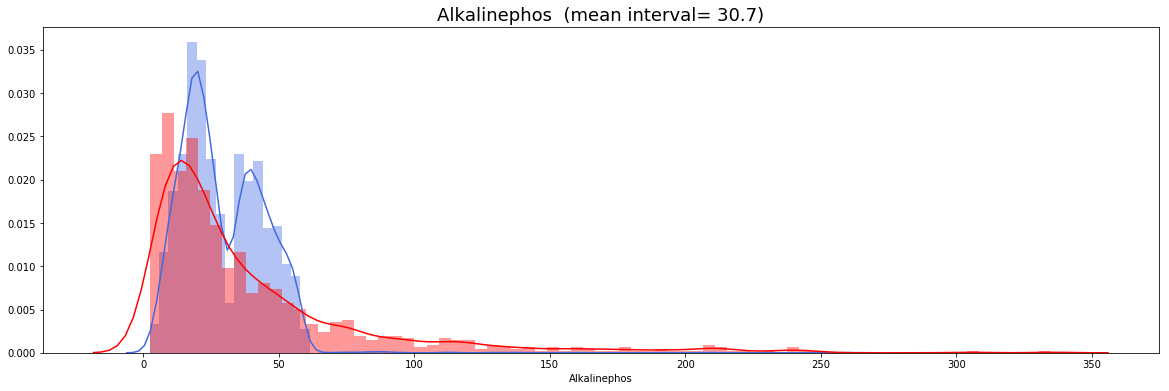

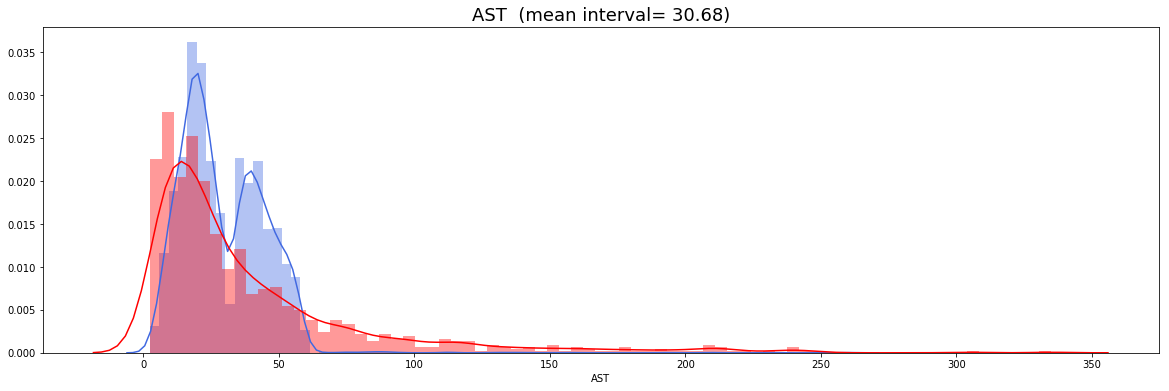

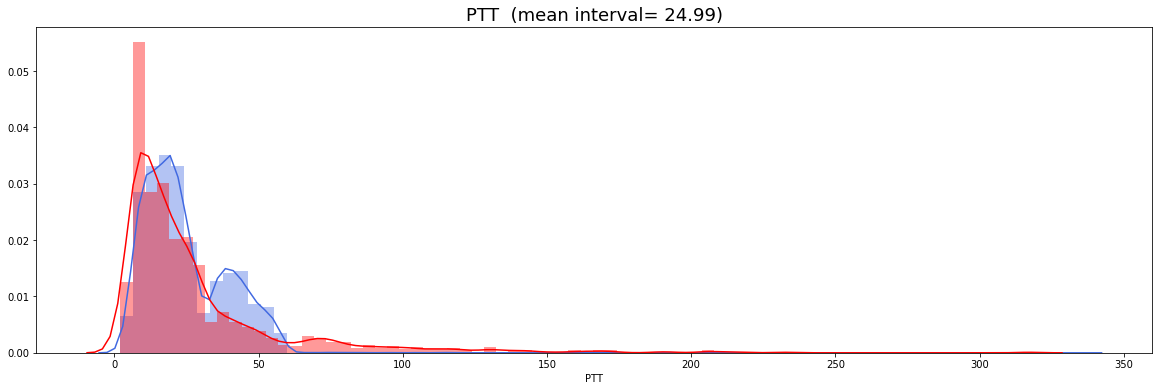

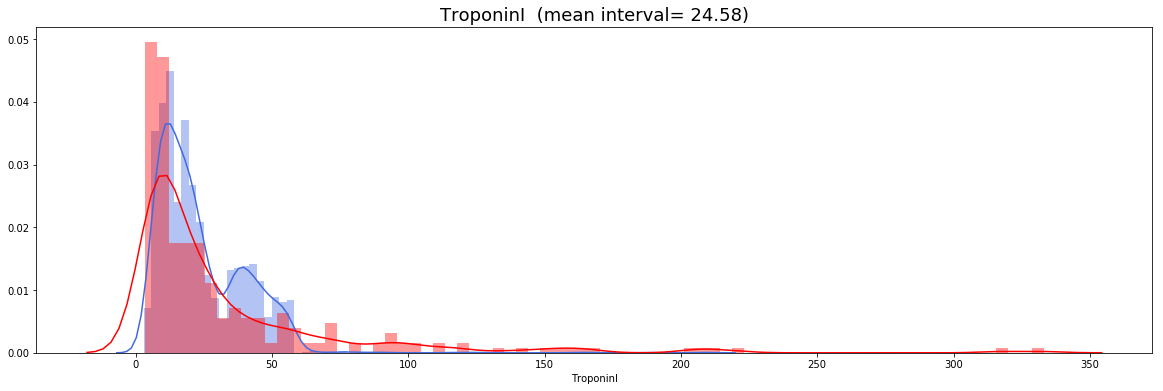

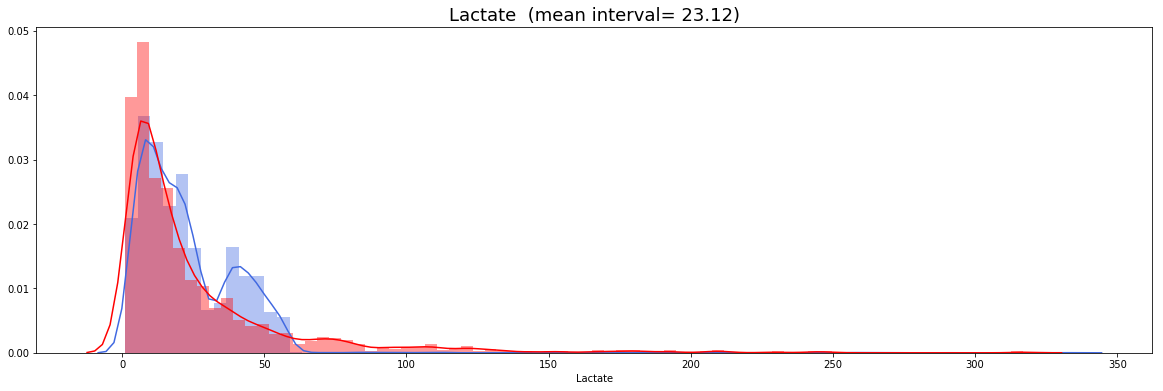

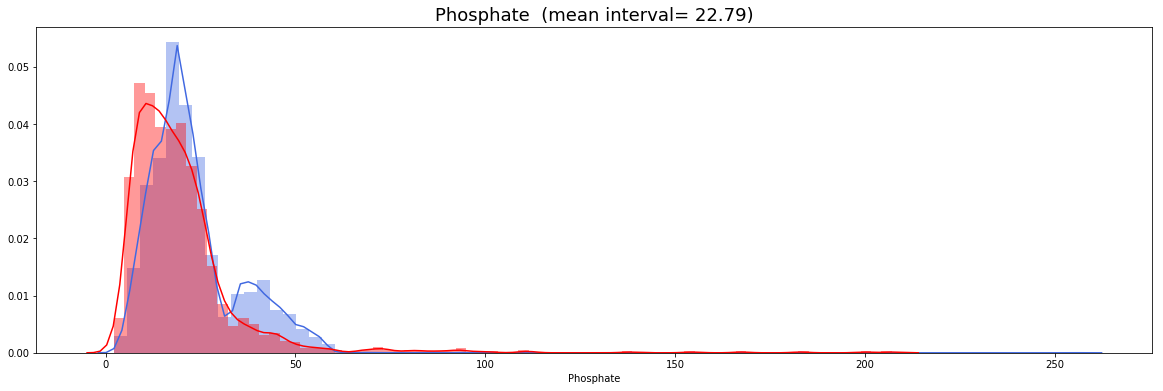

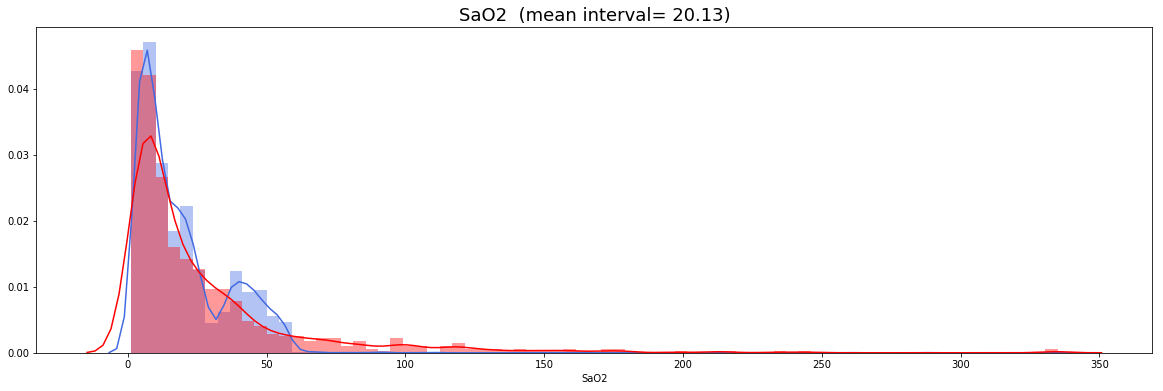

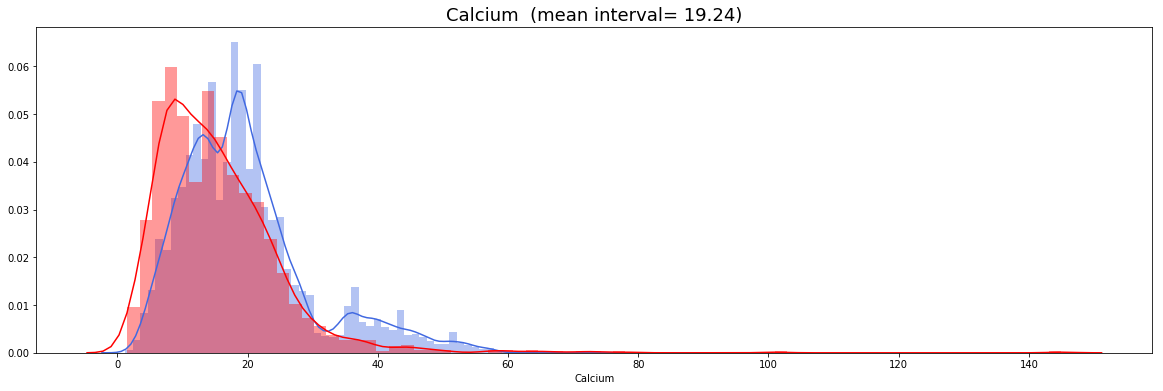

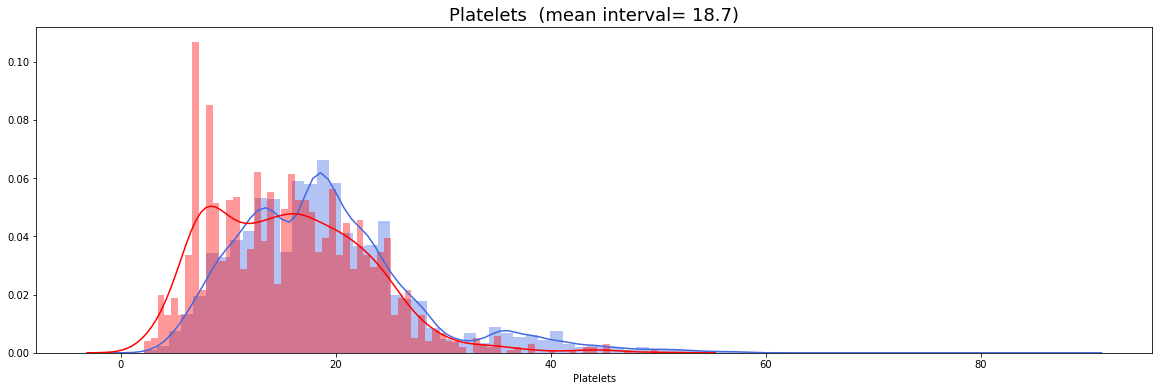

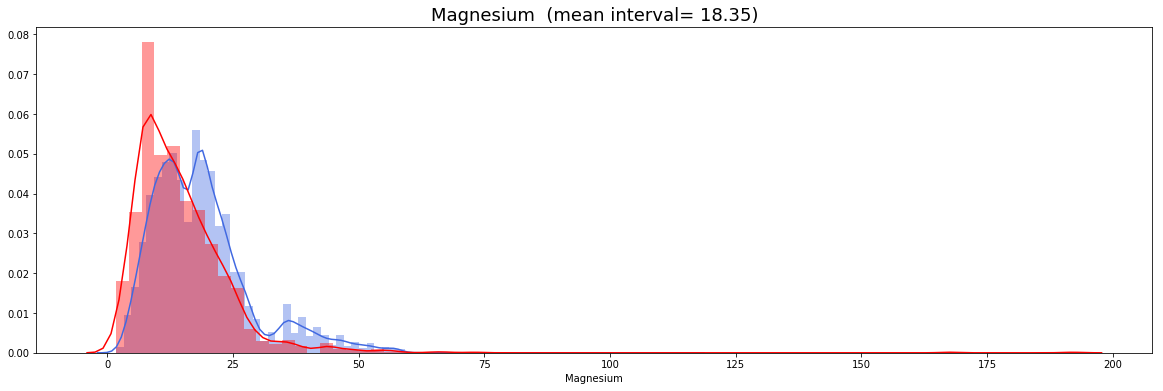

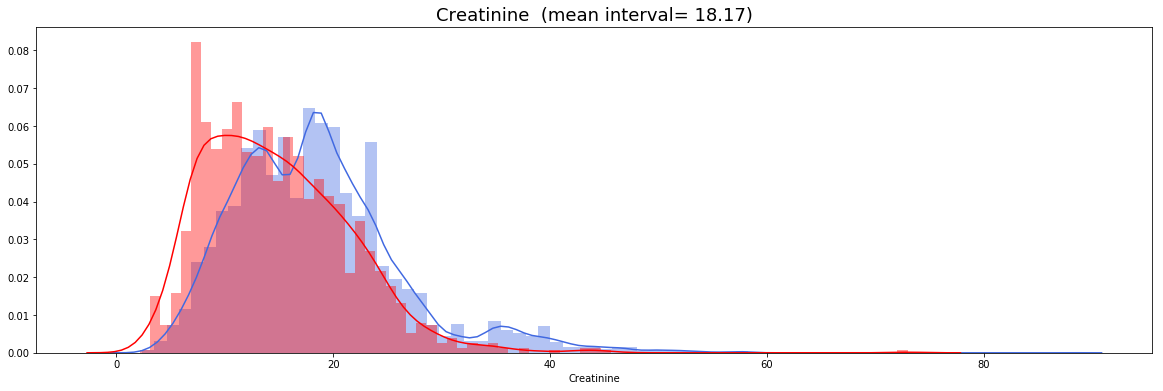

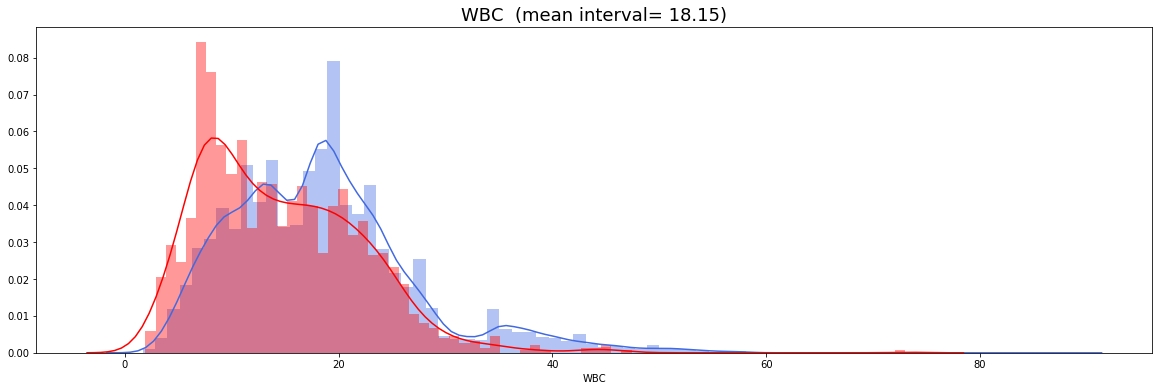

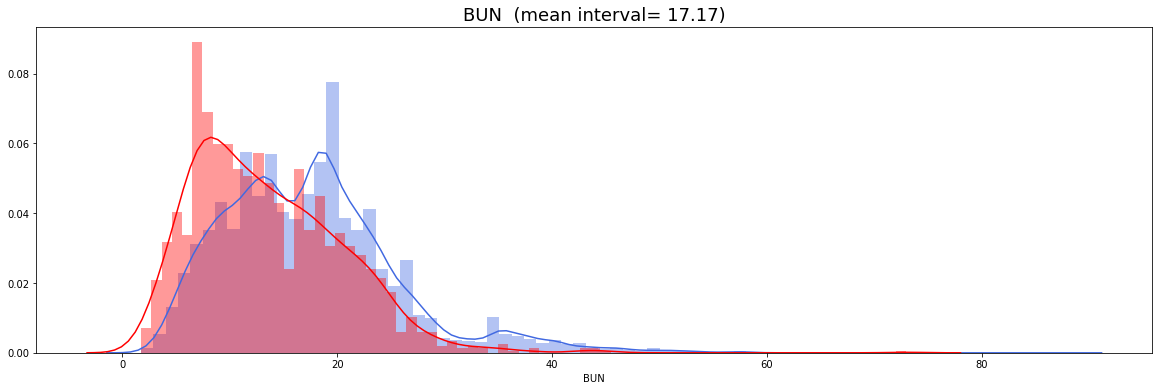

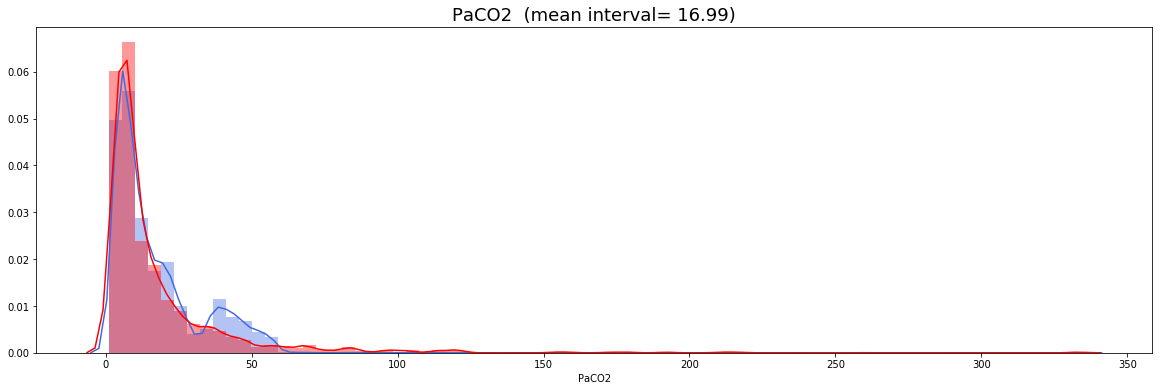

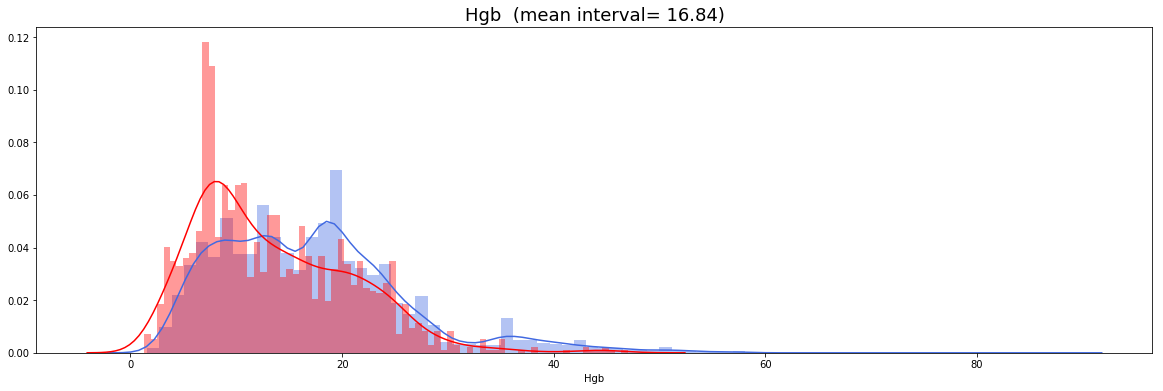

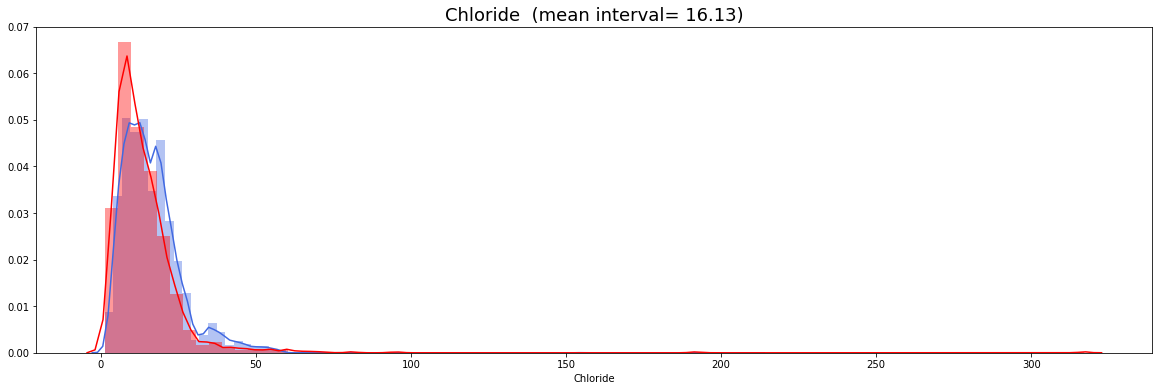

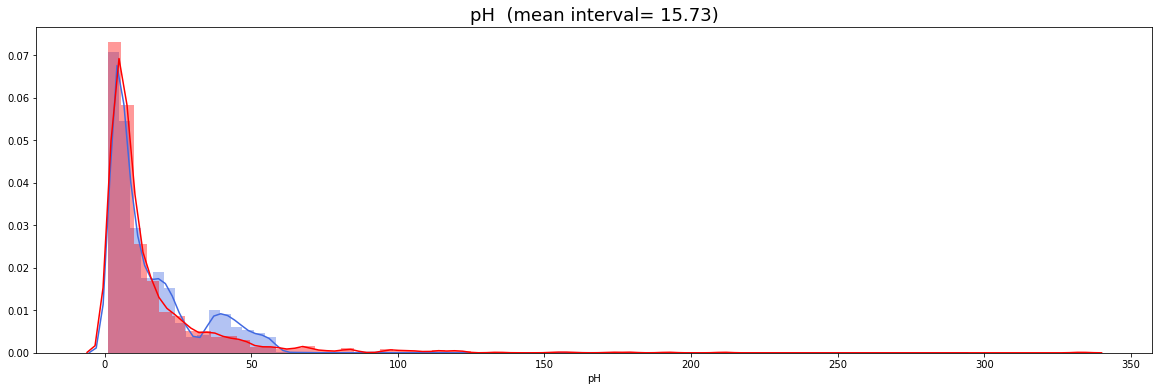

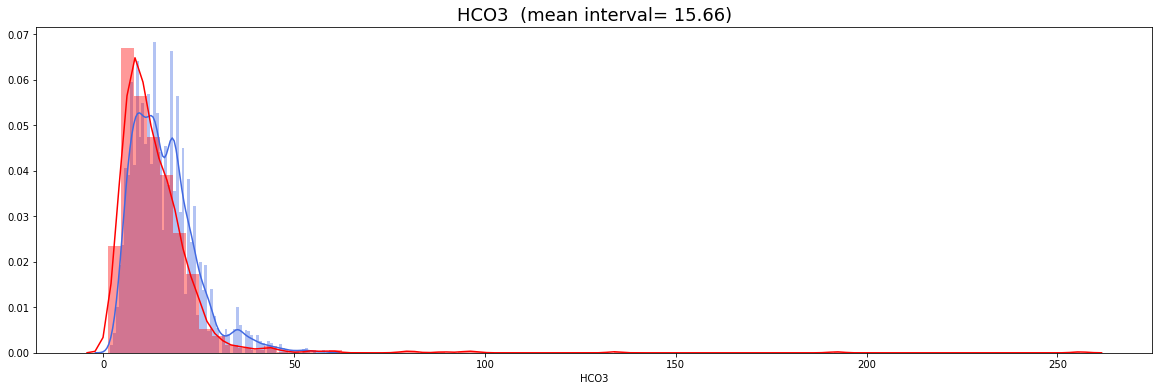

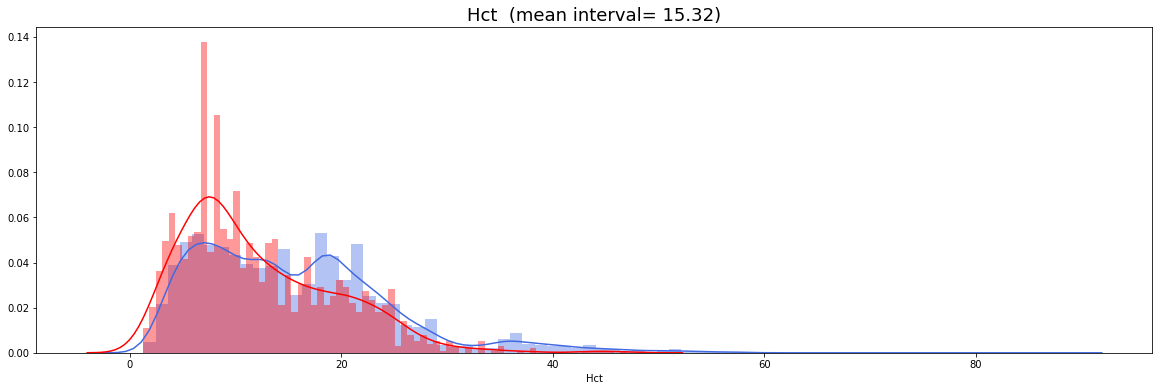

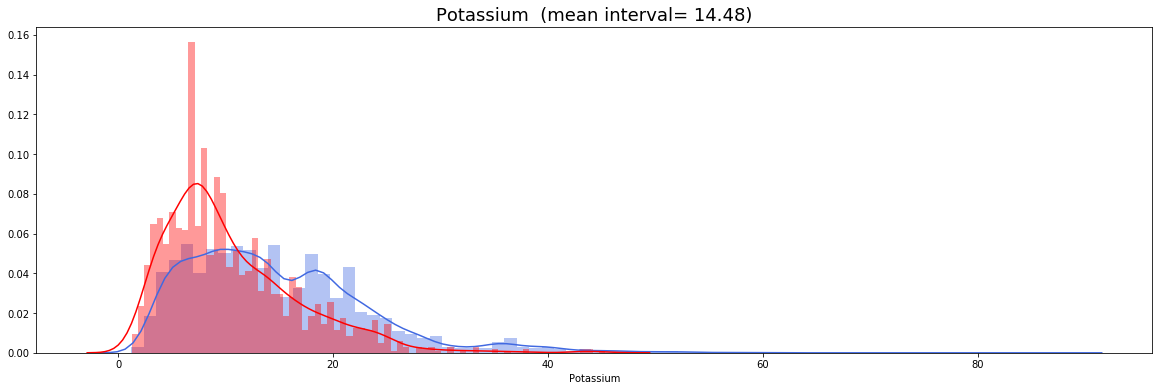

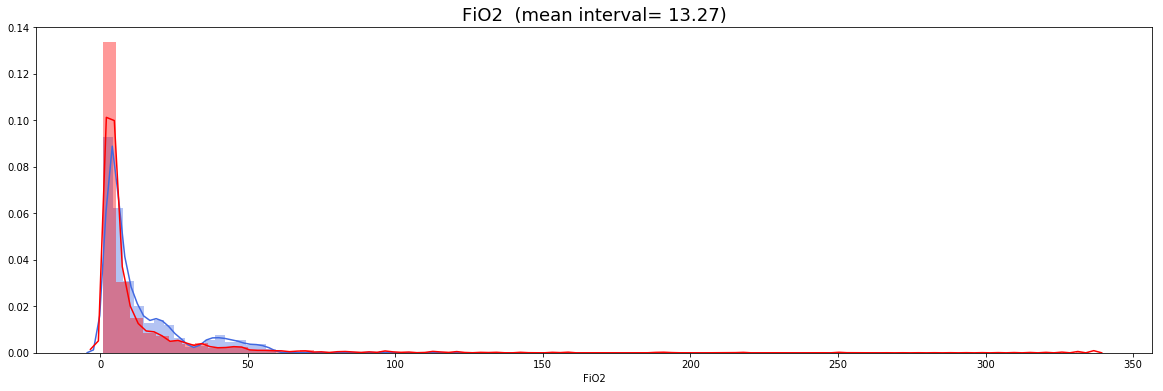

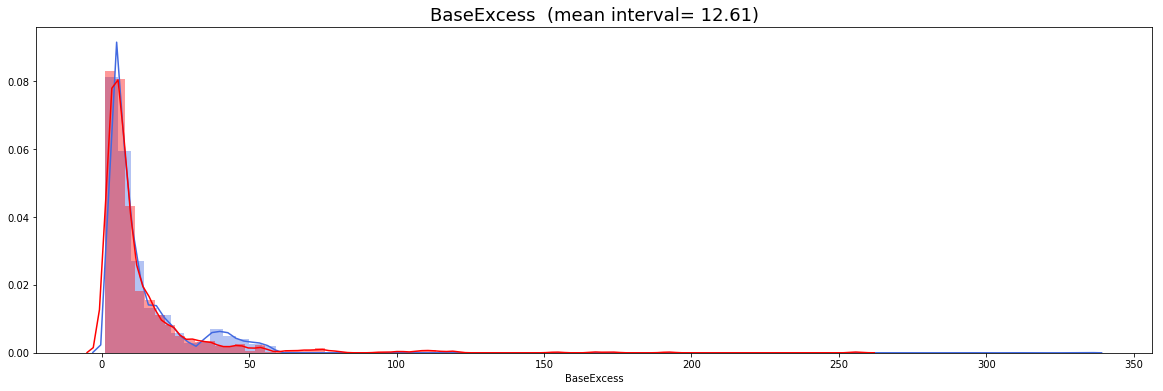

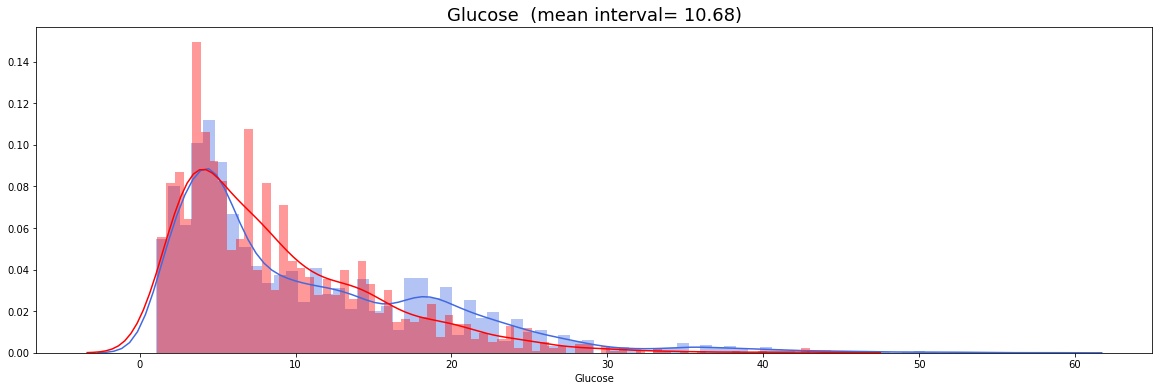

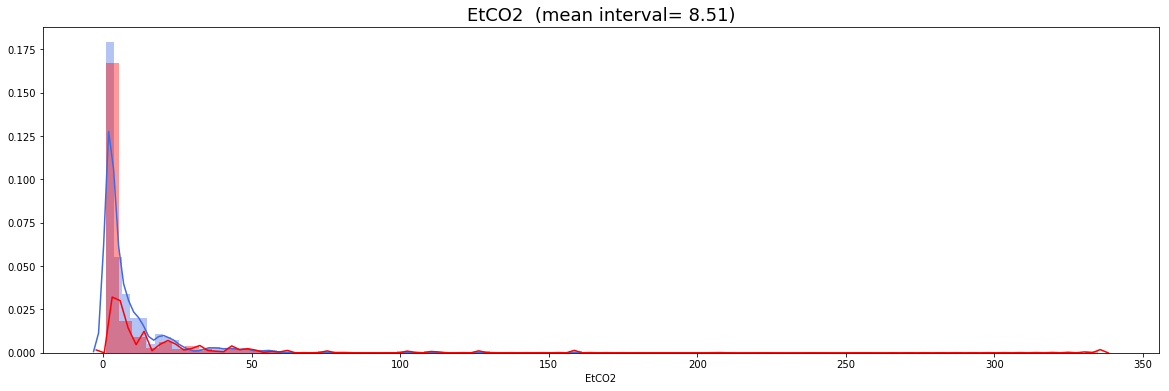

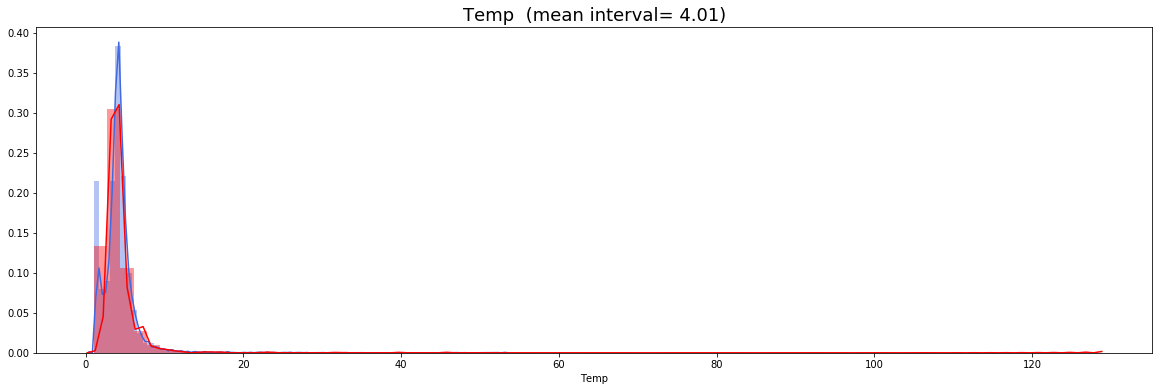

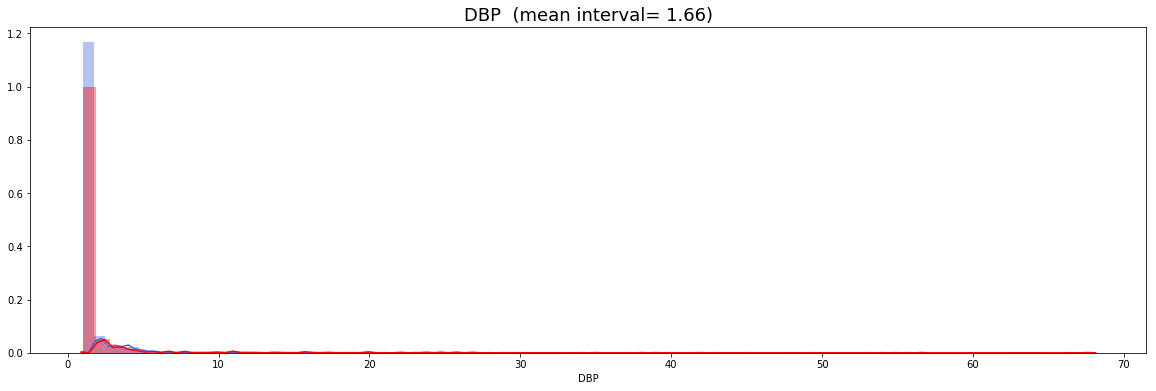

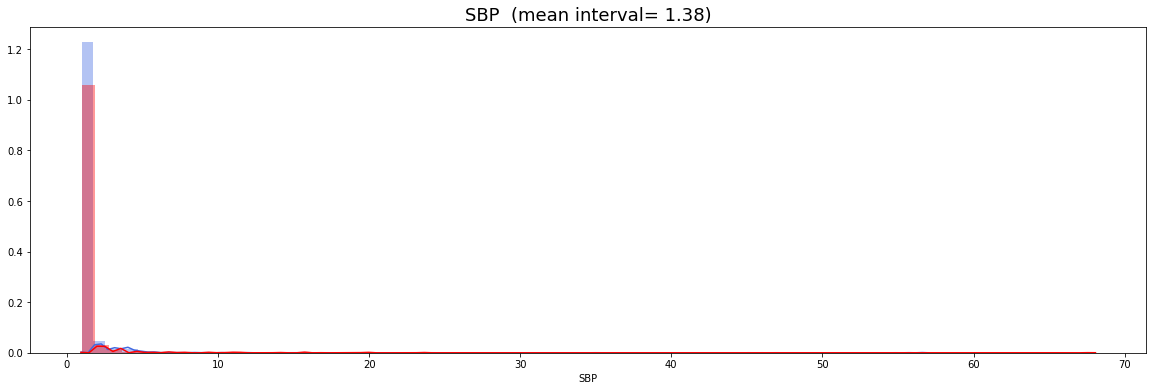

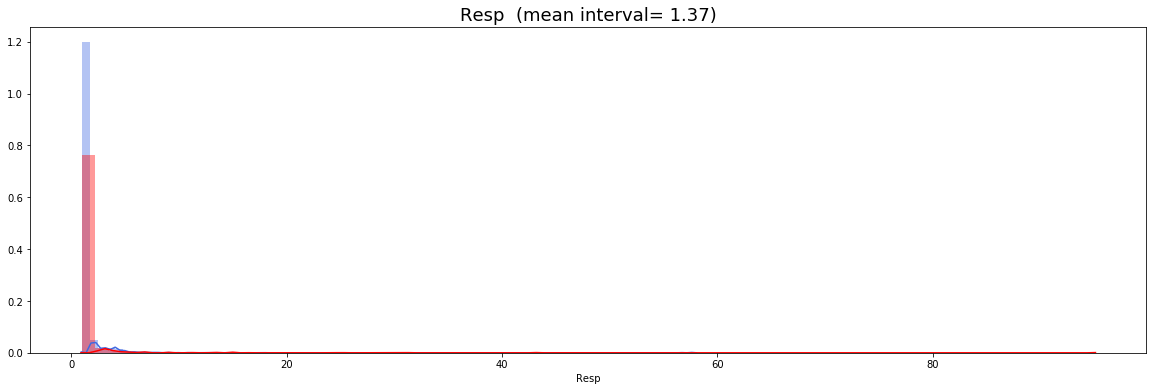

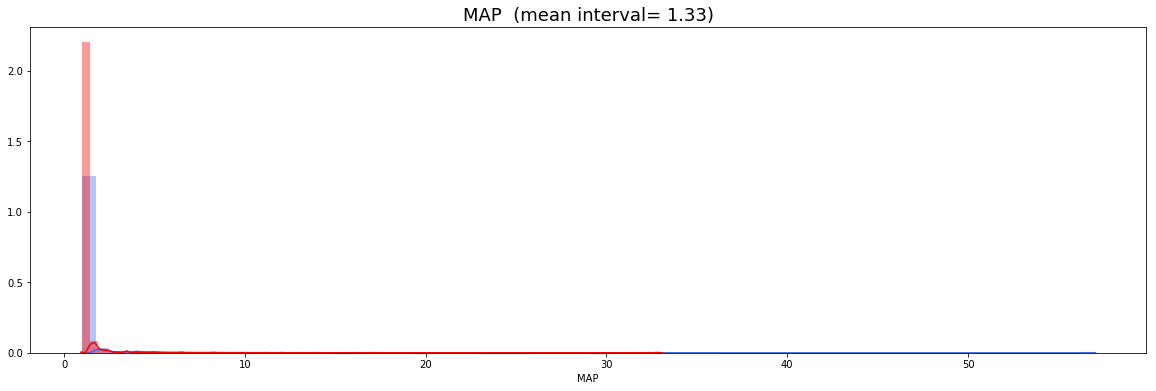

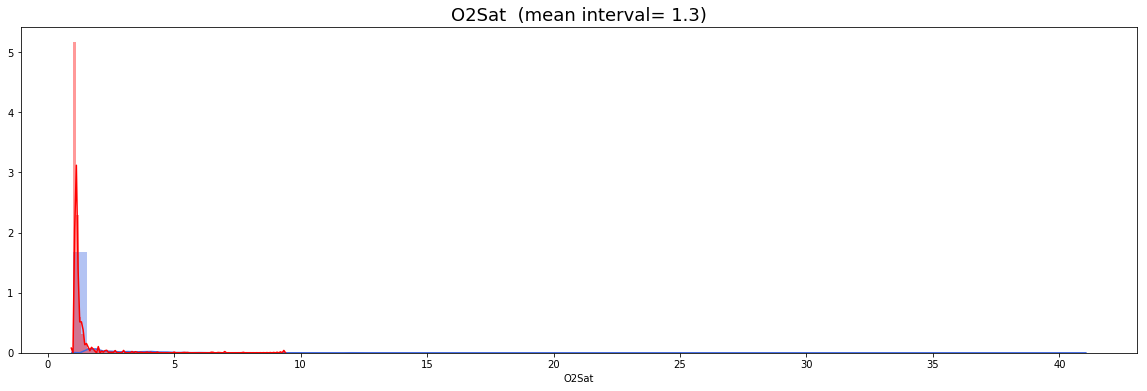

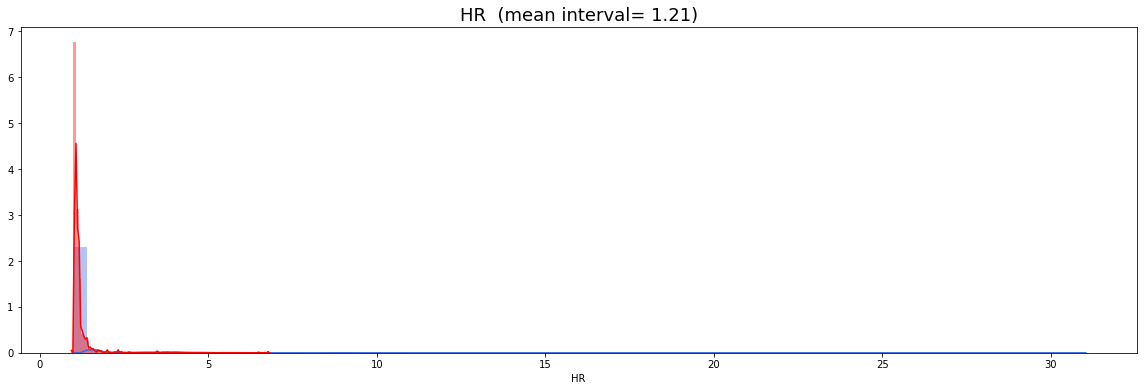

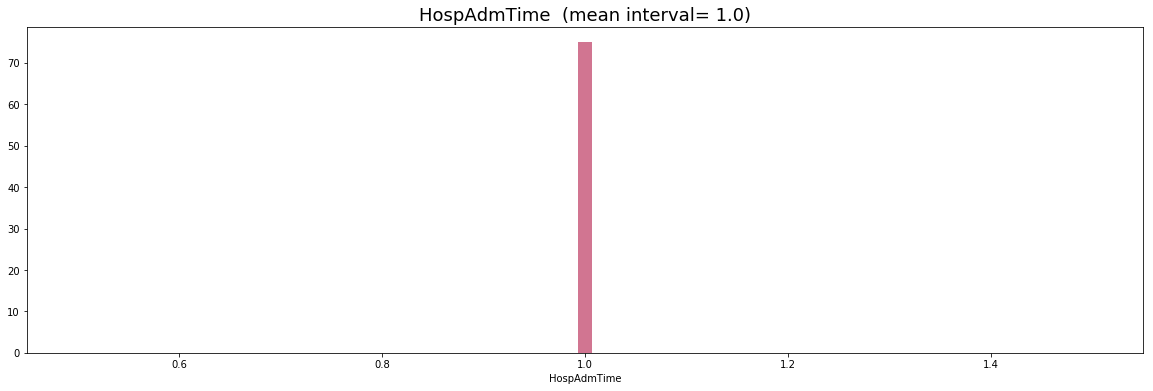

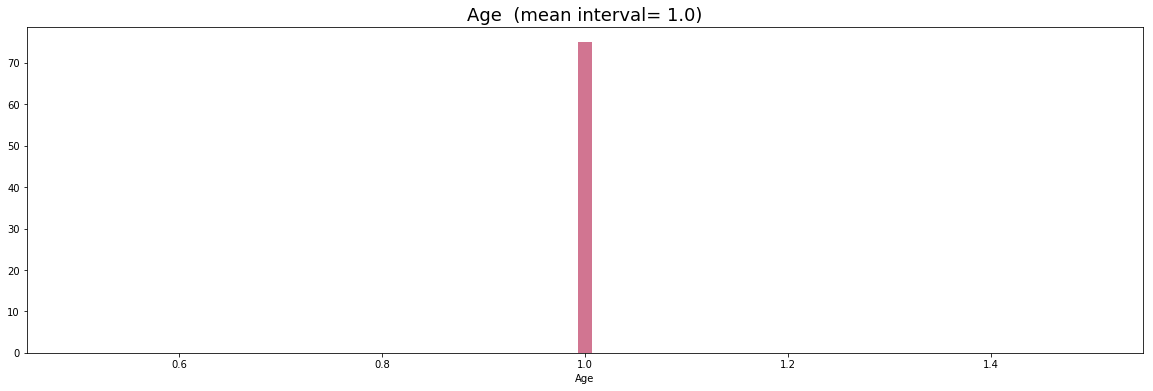

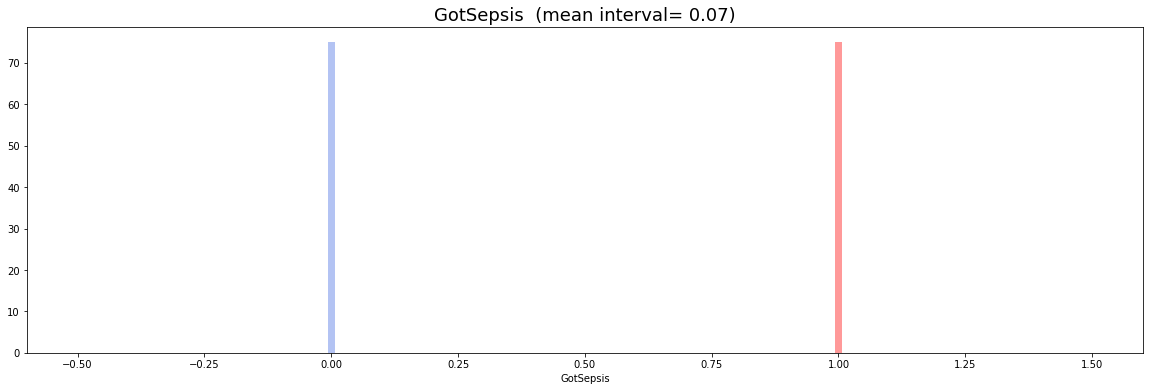

In [829]:
plot_histograms(time_between_collections, ascend = False, count_interval = "interval")

### Sample and Hold Approach

In [21]:
ffill_limits = np.ceil(time_between_collections.mean())
ffill_limits.head(10)

HR             2.0
O2Sat          2.0
Temp           5.0
SBP            2.0
MAP            2.0
DBP            2.0
Resp           2.0
EtCO2          9.0
BaseExcess    13.0
HCO3          16.0
dtype: float64

In [23]:
def sample_and_hold(data, catvars, missing_threshold = 70):
    
    numeric = data[data.columns[~data.columns.isin(catvars)]]
    cat = data[data.columns[data.columns.isin(catvars)]]

    # limited ffill imputation
    def limited_ffill(column):
        column = column.fillna(method = 'ffill', limit = np.asscalar(ffill_limits[column.name].astype('int')))
        return(column)
    numeric = numeric.groupby('filename').apply(lambda df: df.apply(limited_ffill))
    
    # recombine numeric and categorical columns
    data = pd.concat([numeric.reset_index(), cat.reset_index(drop=True)], sort=False, axis=1).set_index('filename')

    # percent missing
    missing_df = percent_missing(data, "Feature Missingness (after sample and hold)", missing_threshold)
    
    # remove missing above 75% after ffill
    data = data[missing_df[missing_df.percent_missing < missing_threshold].index]
    
    # MinMaxScale numeric variables to [0,1]
    scaler = MinMaxScaler()
    data[data.columns[~data.columns.isin(catvars)]] = scaler.fit_transform(data[data.columns[~data.columns.isin(catvars)]])
    
    # Fill in remaining missing values as -1
    imp = SimpleImputer(strategy = 'constant', fill_value = -1)
    data[data.columns[~data.columns.isin(catvars)]] = imp.fit_transform(data[data.columns[~data.columns.isin(catvars)]])
    
    return(data)
################

#catvars = ['Gender', 'Unit1', 'Unit2', 'Hospital', 'SepsisLabel', 'ICULOS', 'GotSepsis']

#train_sah = sample_and_hold(train, catvars, missing_threshold = 80)
#train_sah

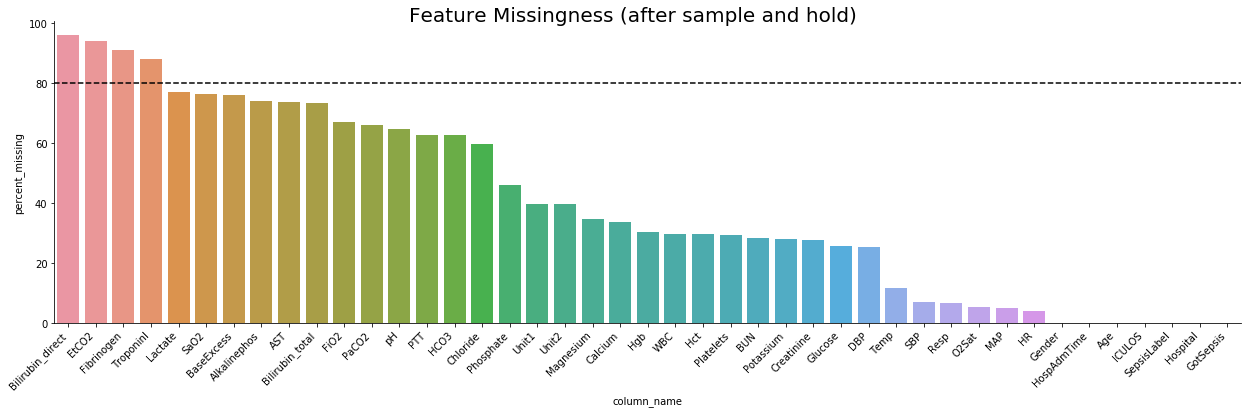

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,Platelets,Age,HospAdmTime,Gender,Unit1,Unit2,ICULOS,SepsisLabel,Hospital,GotSepsis
filename,,,,,,,,,,,,,,,,,,,,,
p000002.psv,-1.000000,-1.0000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,...,-1.0,0.719884,0.979036,0,0.0,1.0,1,0,A,False
p000002.psv,0.157692,0.9875,0.532414,0.376812,0.162455,0.083333,0.168367,-1.0,-1.0,-1.0,...,-1.0,0.719884,0.979036,0,0.0,1.0,2,0,A,False
p000002.psv,0.169231,0.9750,0.532414,0.380435,0.158845,0.076087,0.265306,-1.0,-1.0,-1.0,...,-1.0,0.719884,0.979036,0,0.0,1.0,3,0,A,False
p000002.psv,0.138462,1.0000,0.532414,0.373188,0.162455,0.076087,0.081633,-1.0,-1.0,-1.0,...,-1.0,0.719884,0.979036,0,0.0,1.0,4,0,A,False
p000002.psv,0.176923,0.9875,0.532414,0.362319,0.169675,0.083333,0.224490,-1.0,-1.0,-1.0,...,-1.0,0.719884,0.979036,0,0.0,1.0,5,0,A,False


In [1079]:
catvars = ['Gender', 'Unit1', 'Unit2', 'Hospital', 'SepsisLabel', 'ICULOS', 'GotSepsis']

val_sah = sample_and_hold(val, catvars, missing_threshold = 80)
val_sah.head()

In [1080]:
# Save files 
train_sah.to_csv('train_sample_and_hold_NA_constant.csv')
val_sah.to_csv('val_sample_and_hold_NA_constant.csv')

In [2]:
test = pd.read_csv('sepsis_test.csv')

In [4]:
test = test.drop('Unnamed: 0', axis=1).set_index('filename')
test.shape

(309273, 42)

In [5]:
test['GotSepsis'] = test.groupby('filename').apply(func = lambda x: np.sum(x.SepsisLabel) > 0)
test.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Hospital,GotSepsis
filename,,,,,,,,,,,,,,,,,,,,,
p000001.psv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,1,0,A,False
p000001.psv,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,2,0,A,False
p000001.psv,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,3,0,A,False
p000001.psv,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,4,0,A,False
p000001.psv,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,5,0,A,False


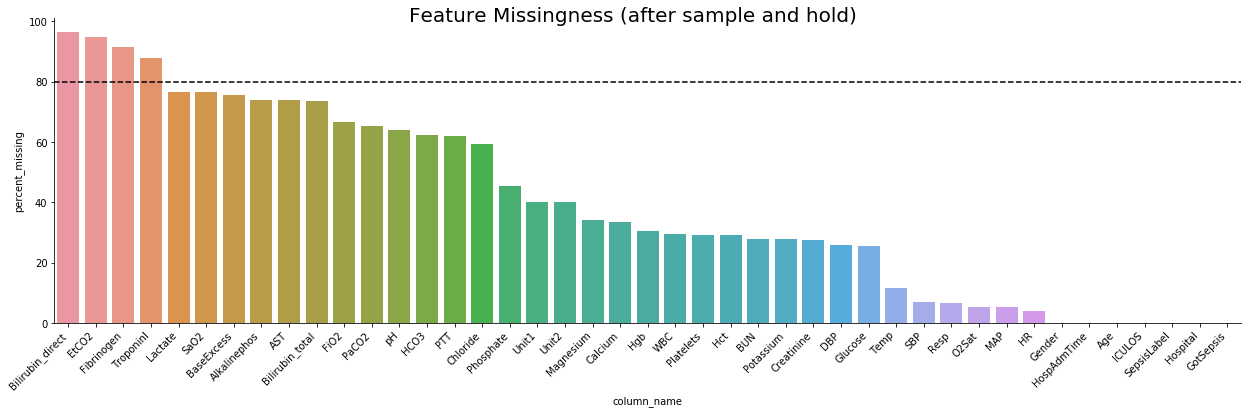

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,Platelets,Age,HospAdmTime,Gender,Unit1,Unit2,ICULOS,SepsisLabel,Hospital,GotSepsis
filename,,,,,,,,,,,,,,,,,,,,,
p000001.psv,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,...,-1.000000,0.801647,0.996261,0,NaN,NaN,1,0,A,False
p000001.psv,0.450292,0.93750,-1.000000,0.282609,0.197607,-1.000000,0.181818,-1.000000,-1.000000,-1.00000,...,-1.000000,0.801647,0.996261,0,NaN,NaN,2,0,A,False
p000001.psv,0.403509,0.98750,-1.000000,0.369565,0.235714,-1.000000,0.212121,-1.000000,-1.000000,-1.00000,...,-1.000000,0.801647,0.996261,0,NaN,NaN,3,0,A,False
p000001.psv,0.409357,0.93750,-1.000000,0.369565,0.235714,-1.000000,0.292929,0.666667,-1.000000,-1.00000,...,-1.000000,0.801647,0.996261,0,NaN,NaN,4,0,A,False
p000001.psv,0.485380,0.85625,-1.000000,0.369565,0.254750,-1.000000,0.237374,0.666667,-1.000000,0.00007,...,-1.000000,0.801647,0.996261,0,NaN,NaN,5,0,A,False
p000001.psv,0.526316,0.88750,-1.000000,0.369565,0.254750,-1.000000,0.212121,0.666667,-1.000000,0.00007,...,-1.000000,0.801647,0.996261,0,NaN,NaN,6,0,A,False
p000001.psv,0.514620,0.90000,0.634000,0.373188,0.203571,-1.000000,0.282828,0.666667,-1.000000,0.00007,...,-1.000000,0.801647,0.996261,0,NaN,NaN,7,0,A,False
p000001.psv,0.502924,0.88125,0.634000,0.264493,0.201179,-1.000000,0.282828,0.666667,-1.000000,0.00007,...,-1.000000,0.801647,0.996261,0,NaN,NaN,8,0,A,False
p000001.psv,0.491228,0.93750,0.634000,0.409420,0.244036,-1.000000,0.252525,0.666667,-1.000000,0.00007,...,-1.000000,0.801647,0.996261,0,NaN,NaN,9,0,A,False


In [24]:
catvars = ['Gender', 'Unit1', 'Unit2', 'Hospital', 'SepsisLabel', 'ICULOS', 'GotSepsis']

test_sah = sample_and_hold(test, catvars, missing_threshold = 80)
test_sah

In [25]:
test_sah.to_csv('test_sample_and_hold_NA_constant.csv')